In [1]:
import pandas as pd
import numpy as np
import requests
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')
from sklearn.metrics import r2_score
from sklearn.cluster import KMeans
import statsmodels.api as sm
from colorama import Fore, Style
from scipy.optimize import fsolve, curve_fit
import yfinance as yf
import akshare as ak
import sys
sys.path.append('../src') 
from utils import plot_candlestick, get_optimum_clusters, exponential_func

from chinese_etf_strategy import etf_strategy, etf_regression
from chinese_commodity_strategy import commodity_strategy

## Some sample code that're working

In [2]:
# Tongxin ETF, changnei, history
etf_code = "sh515880"  # ETF代码
etf_hist = ak.fund_etf_hist_sina(symbol=etf_code)
etf_hist.tail()

date   open   high    low  close      volume
1455  2025-09-08  2.474  2.480  2.300  2.394  1089711654
1456  2025-09-09  2.347  2.398  2.302  2.346   526237109
1457  2025-09-10  2.426  2.496  2.398  2.452   852625786
1458  2025-09-11  2.500  2.697  2.489  2.697  1170063122
1459  2025-09-12  2.603  2.669  2.590  2.623  1000225657

In [3]:
# Tongxin ETF, changnei, realtime
df = ak.fund_etf_spot_ths()
df[df['基金代码']=='515880']

序号    基金代码           基金名称  当前-单位净值  当前-累计净值  前一日-单位净值  前一日-累计净值  \
1212  1213  515880  国泰中证全指通信设备ETF   2.6239   2.6239    2.6755    2.6755   

         增长值   增长率 赎回状态 申购状态      最新-交易日  最新-单位净值  最新-累计净值 基金类型        查询日期  
1212 -0.0516 -1.93   开放   开放  2025-09-12   2.6239   2.6239  股票型  2025-09-12

In [4]:
# Tongxin ETF, changnei, lishi and shishi
etf_code = "515880"  # ETF代码
start_date = (datetime.today() - relativedelta(years=3)).strftime('%Y%m%d')   # 开始日期
end_date = datetime.today().strftime('%Y%m%d')  # 结束日期

etf_hist = ak.fund_etf_hist_em(symbol=etf_code, period="daily", start_date=start_date, end_date=end_date, adjust="")
etf_hist.rename(columns={"日期": 'date', "开盘": 'open', "收盘": 'close', "最高": 'high', "最低": 'low', "成交量": 'volume', "成交额": 'amount'}, inplace=True)
etf_hist.tail()

  0%|          | 0/12 [00:00<?, ?it/s]

date   open  close   high    low    volume        amount    振幅  \
724  2025-09-08  2.474  2.394  2.480  2.300  10897117  2.591967e+09  7.15   
725  2025-09-09  2.347  2.346  2.398  2.302   5262371  1.239024e+09  4.01   
726  2025-09-10  2.426  2.452  2.496  2.398   8526258  2.084530e+09  4.18   
727  2025-09-11  2.500  2.697  2.697  2.489  11700631  3.059268e+09  8.48   
728  2025-09-12  2.603  2.623  2.669  2.590  10002257  2.630954e+09  2.93   

      涨跌幅    涨跌额    换手率  
724 -4.92 -0.124  24.59  
725 -2.01 -0.048  11.88  
726  4.52  0.106  19.24  
727  9.99  0.245  26.40  
728 -2.74 -0.074  22.57

In [5]:
# Huangjin, history
spot_hist_sge_df = ak.spot_hist_sge(symbol='Au99.99')
spot_hist_sge_df['date']= pd.to_datetime(spot_hist_sge_df['date'])
spot_hist_sge_df.tail()

date   open   close    low    high
2117 2025-09-08  810.3  821.20  810.3  822.00
2118 2025-09-09  823.0  832.00  823.0  833.99
2119 2025-09-10  832.0  829.75  824.5  836.00
2120 2025-09-11  830.0  826.52  825.8  832.80
2121 2025-09-12  825.0  830.41  824.1  831.70

In [6]:
last_49day_price = spot_hist_sge_df['close'][-50:-1]
p_ma = np.mean(last_49day_price)
print('50MA break point:', round(p_ma,2))

50MA break point: 781.89


In [7]:
# Huangjin, realtime
spot_quotations_sge_df = ak.spot_quotations_sge(symbol="Au99.99")
spot_quotations_sge_df[spot_quotations_sge_df['时间'] == spot_quotations_sge_df['时间'].max()]

品种        时间     现价                  更新时间
147  Au99.99  02:27:00  831.0  2025年09月15日 02:27:55

In [8]:
spot_quotations_sge_df[spot_quotations_sge_df['时间'] == spot_quotations_sge_df['时间'].max()]['现价']

147    831.0
Name: 现价, dtype: float64

## ALL ETFs

* Current etf price: 0.85
* Recent high: 0.9
* Current etf price is at 95.21% of recent high
Latest 20 Day MA: 0.83
Latest lower Bollinger Band, 20MA: 0.79
Latest higher Bollinger Band, 20MA: 0.88
Latest 50 Day MA: 0.79
Latest lower Bollinger Band, 50MA: 0.69
Latest higher Bollinger Band, 50MA: 0.89
Latest 50 Day EMA: 0.8
Latest 120 Day MA: 0.75
Latest 200 Day MA: 0.75
Latest 200 Day EMA: 0.76
Latest 10 Week MA: 0.8
Latest 20 Week MA: 0.76
Latest 30 Week MA: 0.75
Latest 40 Week MA: 0.75
Latest Lower Weekly Bollinger Band, 20MA: 0.65
Latest Higher Weekly Bollinger Band, 20MA: 0.86

Latest RSI: 59.49 
Latest MACD Divergence: -0.0004 
20MA break point: 0.83
20MA lower Bollinger Band break point: 0.79
20MA Upper Bollinger Band break point: 0.88
50MA break point: 0.79
50MA lower Bollinger Band break point: 0.69
50MA Upper Bollinger Band break point: 0.9
120MA break point: 0.75
200MA break point: 0.75


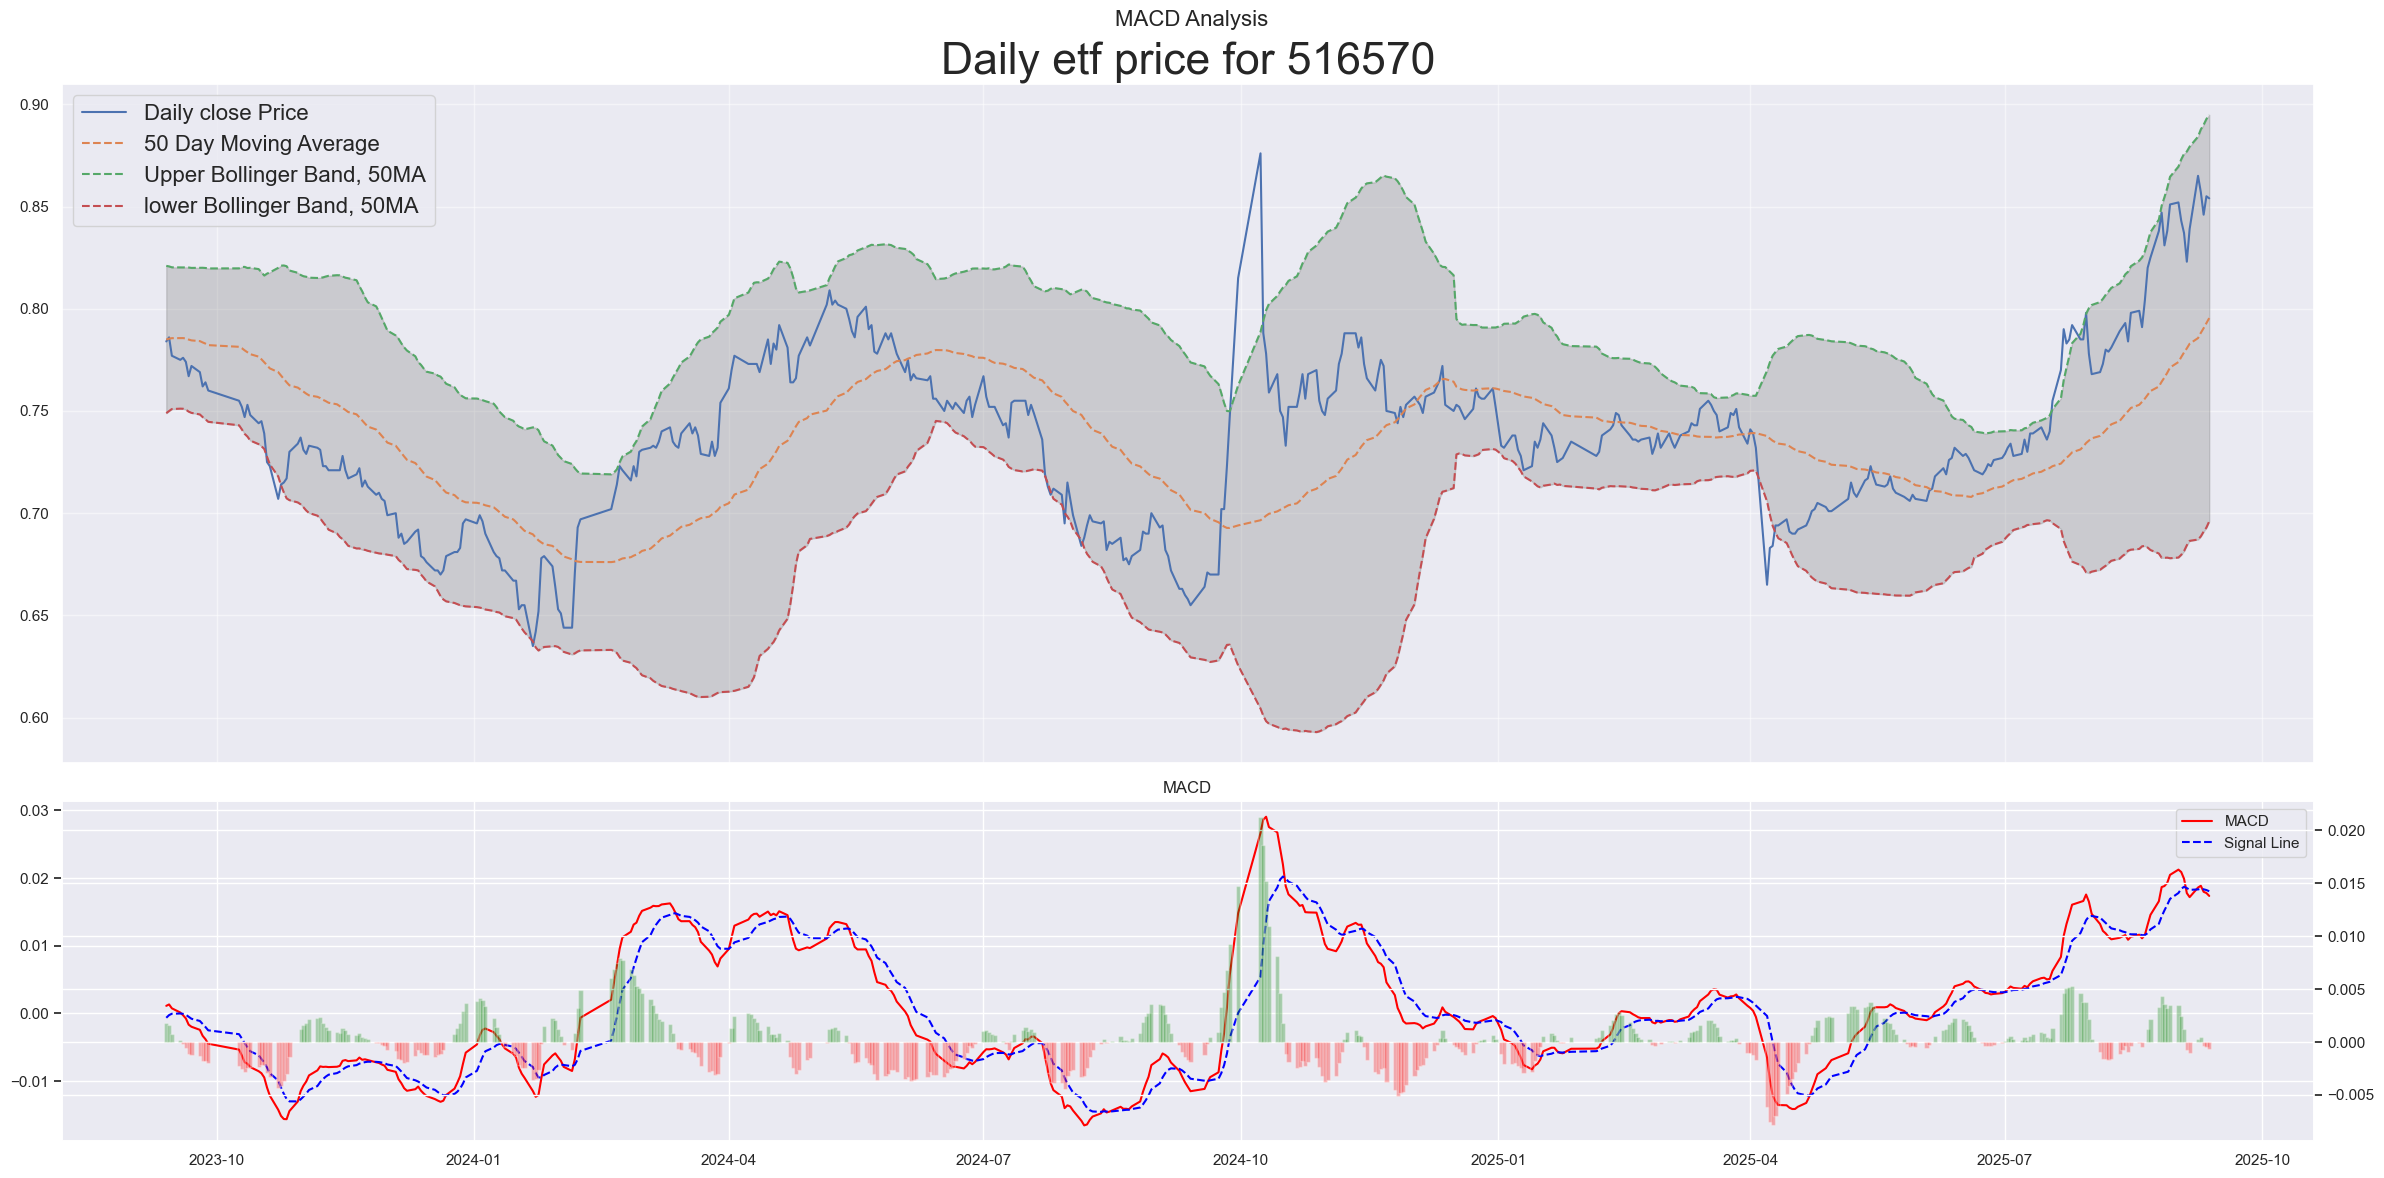

In [9]:
# 石油石化
etf_code = "516570"
etf_strategy(etf_code).output()

* Current etf price: 1.45
* Recent high: 1.6
* Current etf price is at 90.44% of recent high
Latest 20 Day MA: 1.47
Latest lower Bollinger Band, 20MA: 1.44
Latest higher Bollinger Band, 20MA: 1.51
Latest 50 Day MA: 1.51
Latest lower Bollinger Band, 50MA: 1.42
Latest higher Bollinger Band, 50MA: 1.6
Latest 50 Day EMA: 1.48
Latest 120 Day MA: 1.45
Latest 200 Day MA: 1.38
Latest 200 Day EMA: 1.38
Latest 10 Week MA: 1.5
Latest 20 Week MA: 1.47
Latest 30 Week MA: 1.42
Latest 40 Week MA: 1.39
Latest Lower Weekly Bollinger Band, 20MA: 1.35
Latest Higher Weekly Bollinger Band, 20MA: 1.59

Latest RSI: 41.57 
Latest MACD Divergence: -0.0003 
20MA crosses 50MA at 2.57
20MA break point: 1.47
20MA lower Bollinger Band break point: 1.43
20MA Upper Bollinger Band break point: 1.52
50MA break point: 1.51
50MA lower Bollinger Band break point: 1.41
50MA Upper Bollinger Band break point: 1.61
120MA break point: 1.45
200MA break point: 1.38


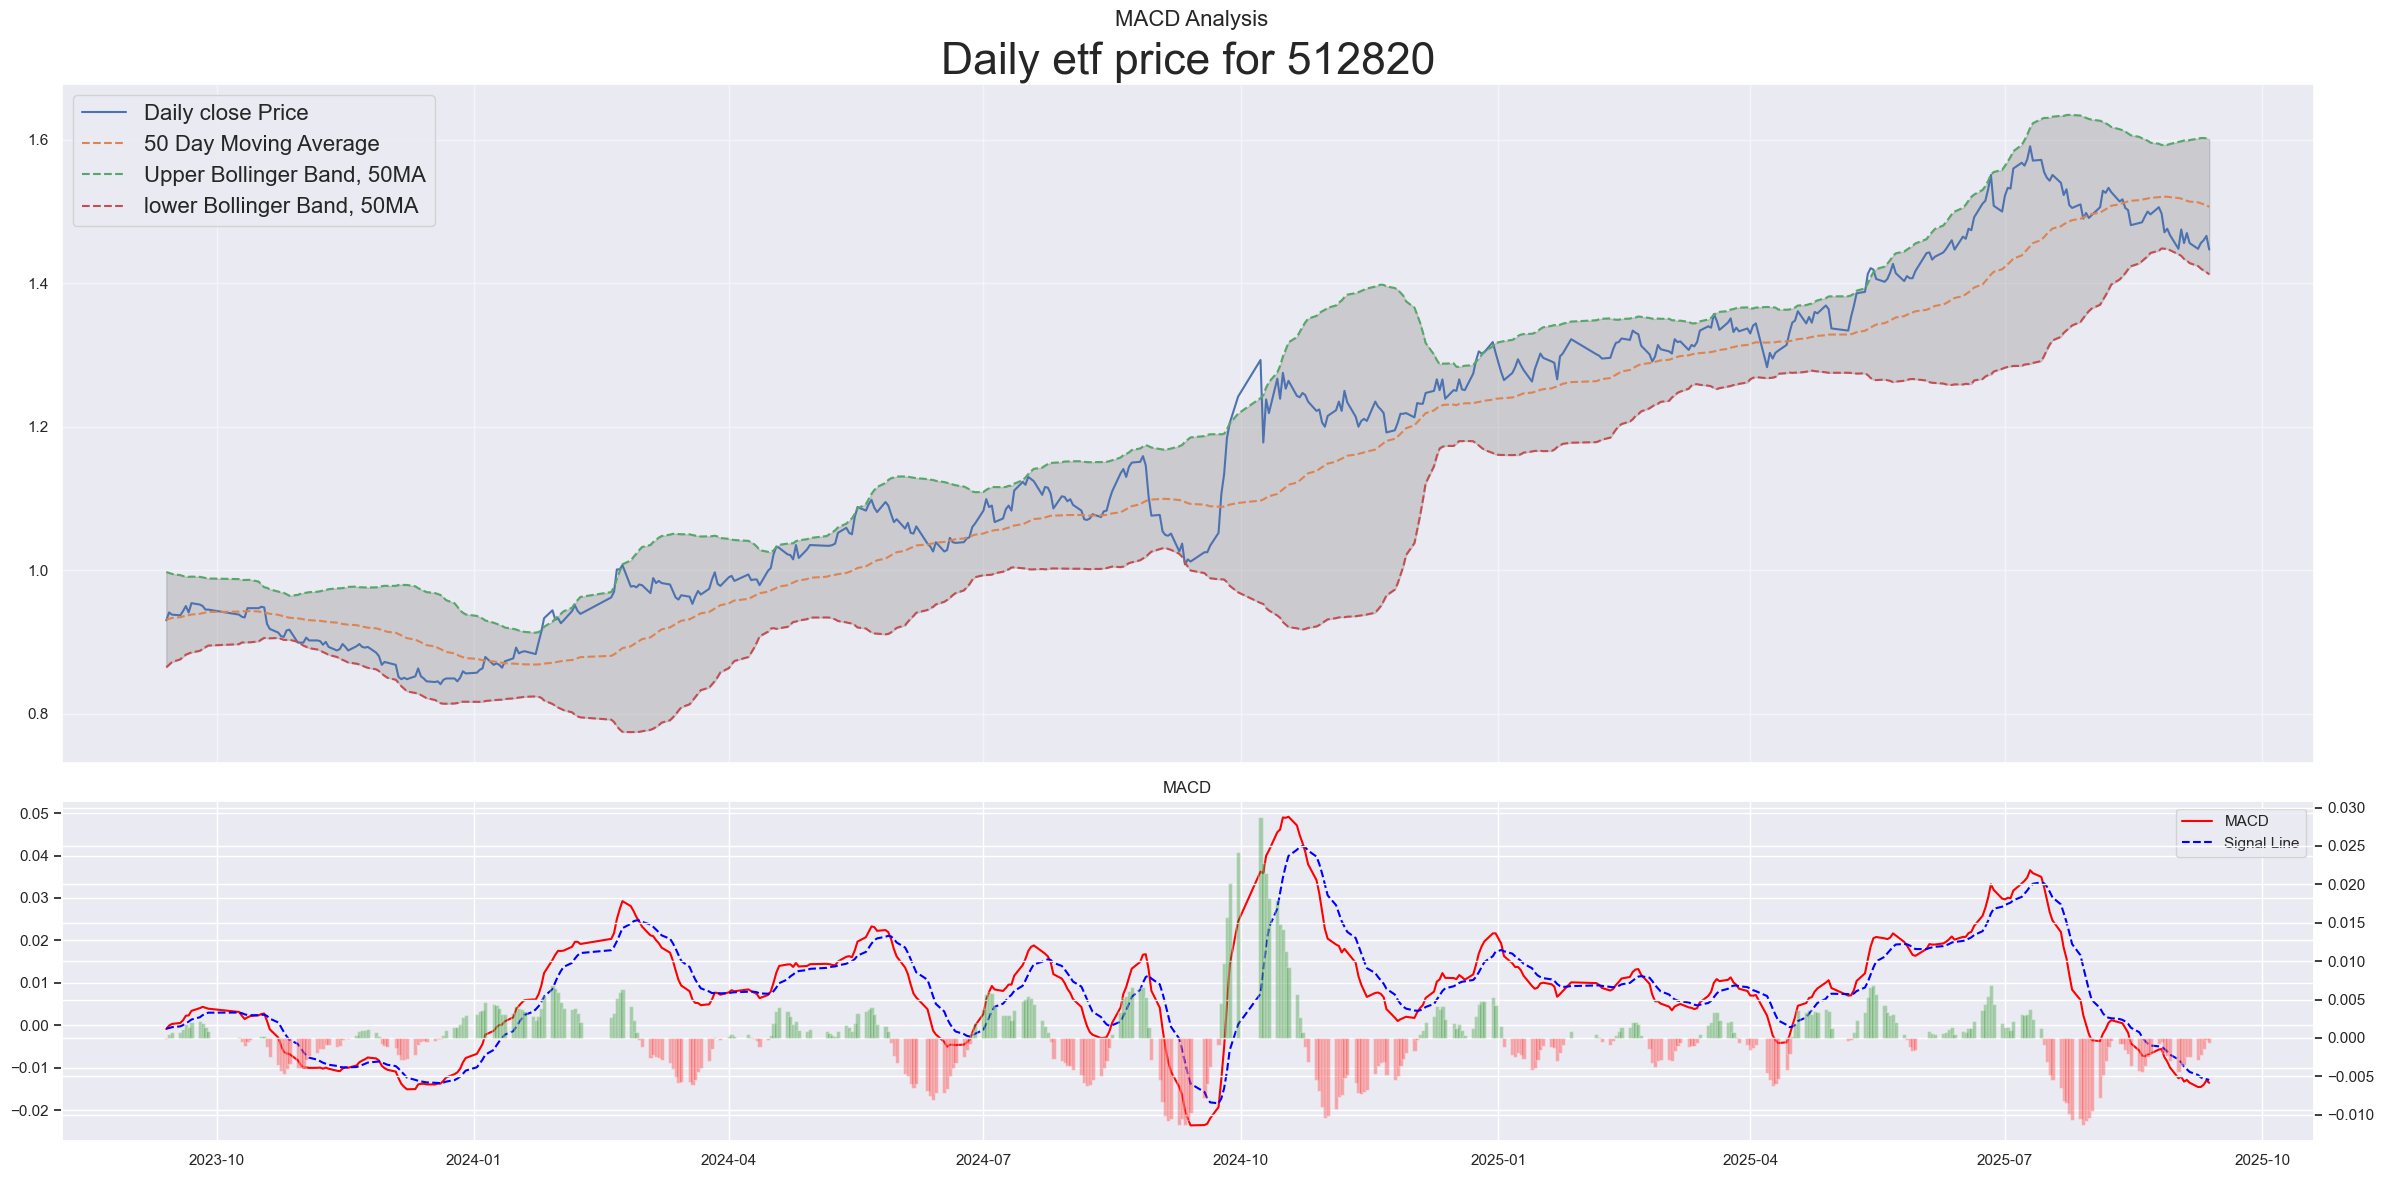

In [10]:
# 中证银行
etf_code = "512820"
etf_strategy(etf_code).output()

* Current etf price: 1.76
* Recent high: 1.79
* Current etf price is at 98.71% of recent high
Latest 20 Day MA: 1.73
Latest lower Bollinger Band, 20MA: 1.68
Latest higher Bollinger Band, 20MA: 1.78
Latest 50 Day MA: 1.67
Latest lower Bollinger Band, 50MA: 1.52
Latest higher Bollinger Band, 50MA: 1.82
Latest 50 Day EMA: 1.68
Latest 120 Day MA: 1.59
Latest 200 Day MA: 1.59
Latest 200 Day EMA: 1.59
Latest 10 Week MA: 1.68
Latest 20 Week MA: 1.61
Latest 30 Week MA: 1.59
Latest 40 Week MA: 1.59
Latest Lower Weekly Bollinger Band, 20MA: 1.43
Latest Higher Weekly Bollinger Band, 20MA: 1.79

Latest RSI: 54.48 
Latest MACD Divergence: -0.0027 
20MA break point: 1.74
20MA lower Bollinger Band break point: 1.68
20MA Upper Bollinger Band break point: 1.79
50MA break point: 1.67
50MA lower Bollinger Band break point: 1.52
50MA Upper Bollinger Band break point: 1.83
120MA break point: 1.59
200MA break point: 1.59


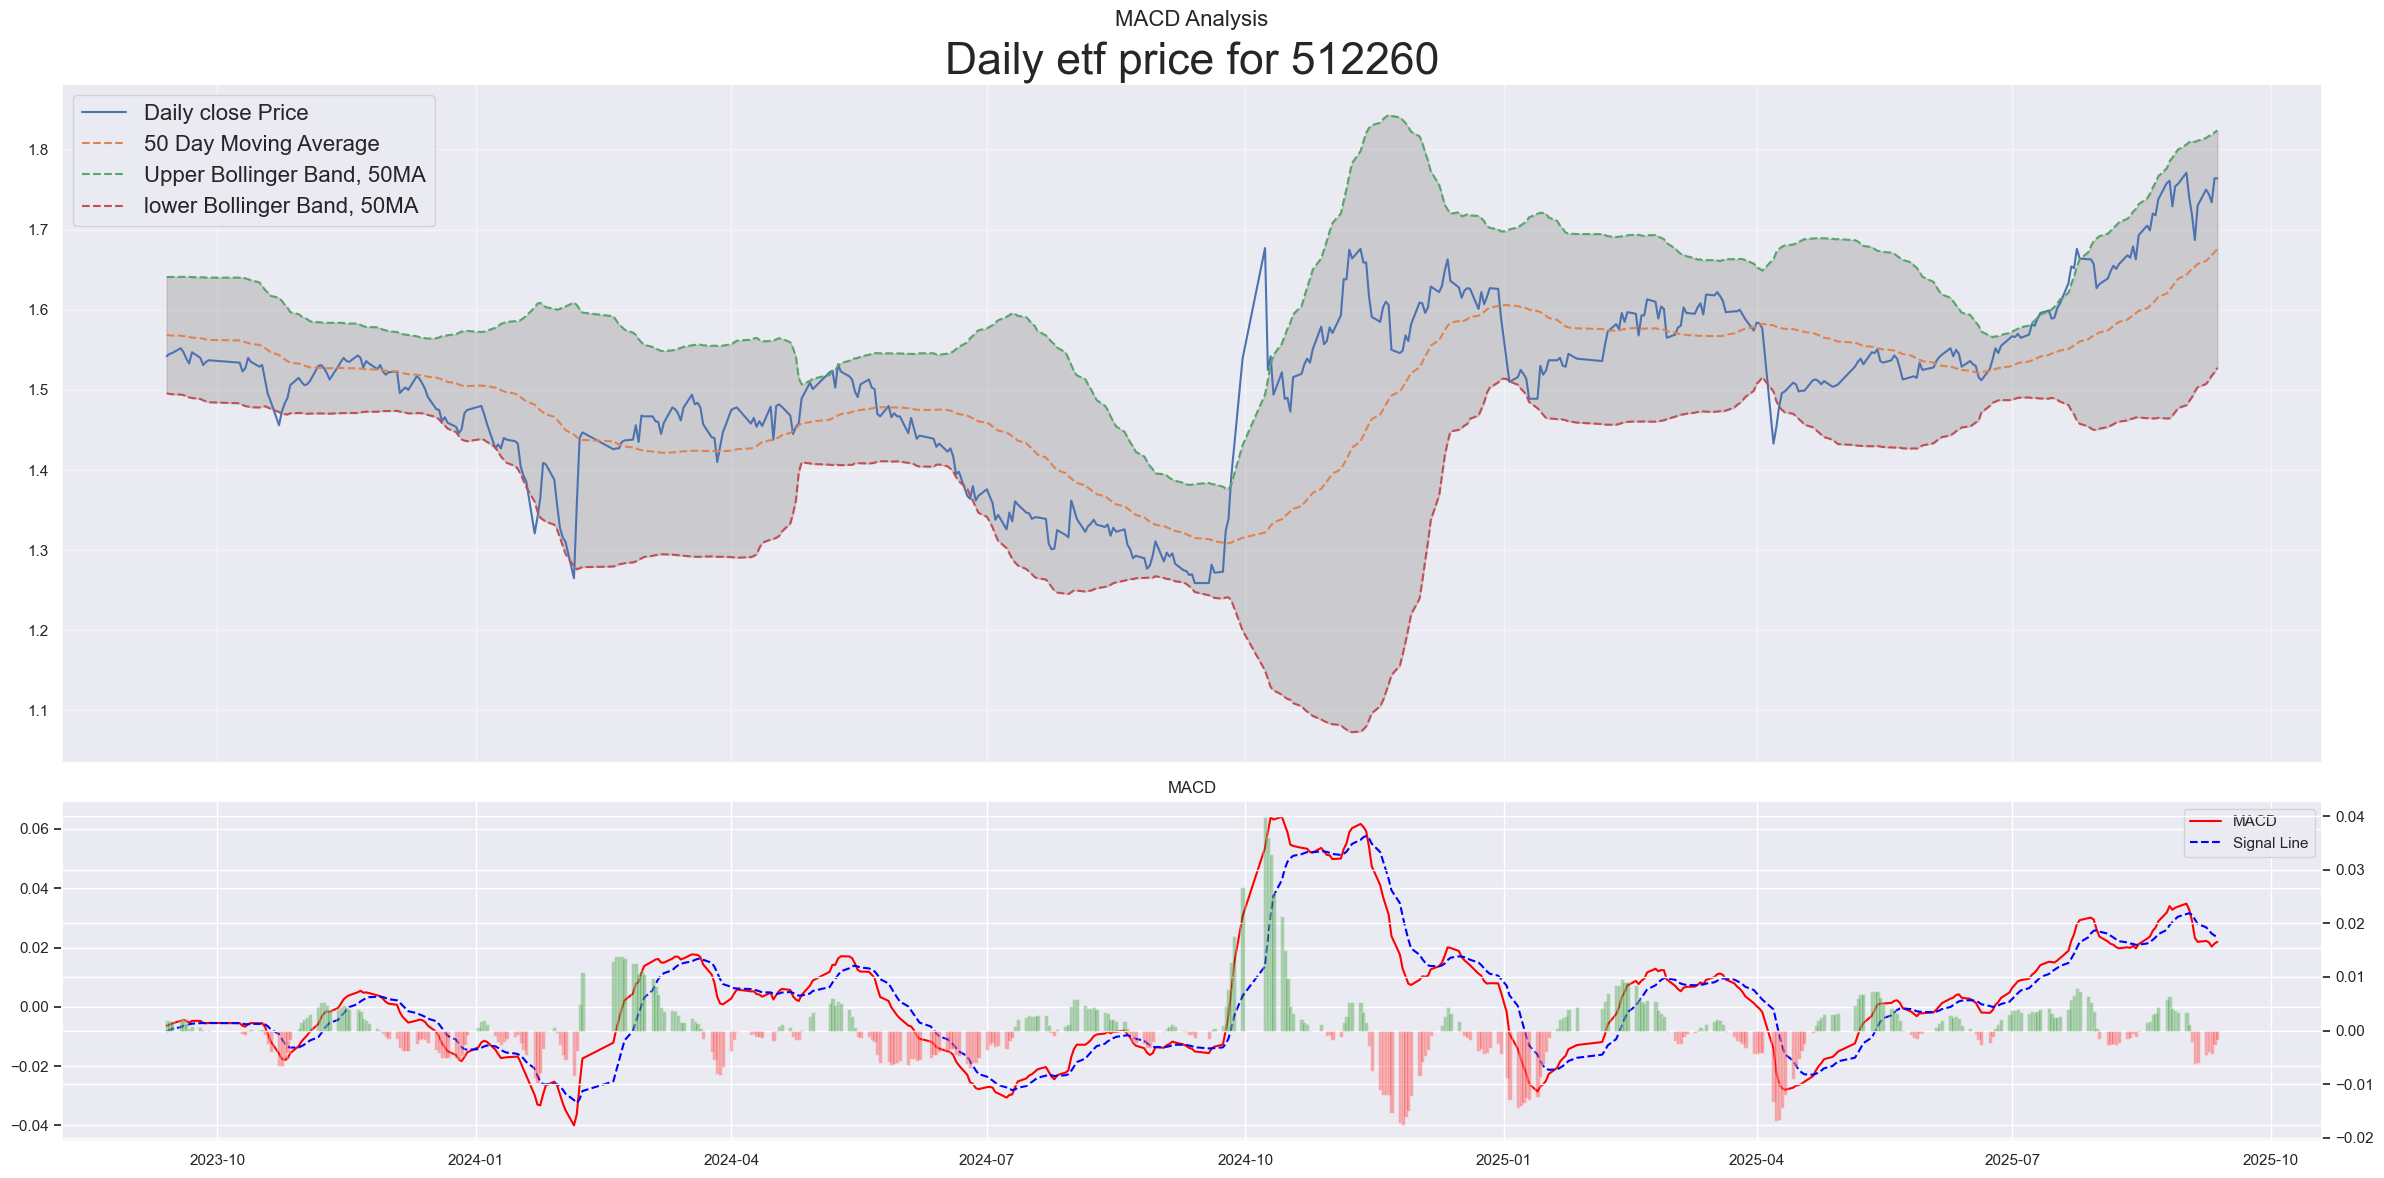

In [11]:
# 500低波
etf_code = "512260"
etf_strategy(etf_code).output()

* Current etf price: 1.37
* Recent high: 1.42
* Current etf price is at 96.33% of recent high
Latest 20 Day MA: 1.29
Latest lower Bollinger Band, 20MA: 1.13
Latest higher Bollinger Band, 20MA: 1.44
Latest 50 Day MA: 1.15
Latest lower Bollinger Band, 50MA: 0.84
Latest higher Bollinger Band, 50MA: 1.46
Latest 50 Day EMA: 1.19
Latest 120 Day MA: 1.08
Latest 200 Day MA: 1.07
Latest 200 Day EMA: 1.05
Latest 10 Week MA: 1.18
Latest 20 Week MA: 1.1
Latest 30 Week MA: 1.09
Latest 40 Week MA: 1.07
Latest Lower Weekly Bollinger Band, 20MA: 0.84
Latest Higher Weekly Bollinger Band, 20MA: 1.35

Latest RSI: 52.83 
Latest MACD Divergence: -0.0111 
20MA break point: 1.29
20MA lower Bollinger Band break point: 1.12
20MA Upper Bollinger Band break point: 1.46
50MA break point: 1.15
50MA lower Bollinger Band break point: 0.82
50MA Upper Bollinger Band break point: 1.49
120MA break point: 1.08
200MA break point: 1.07


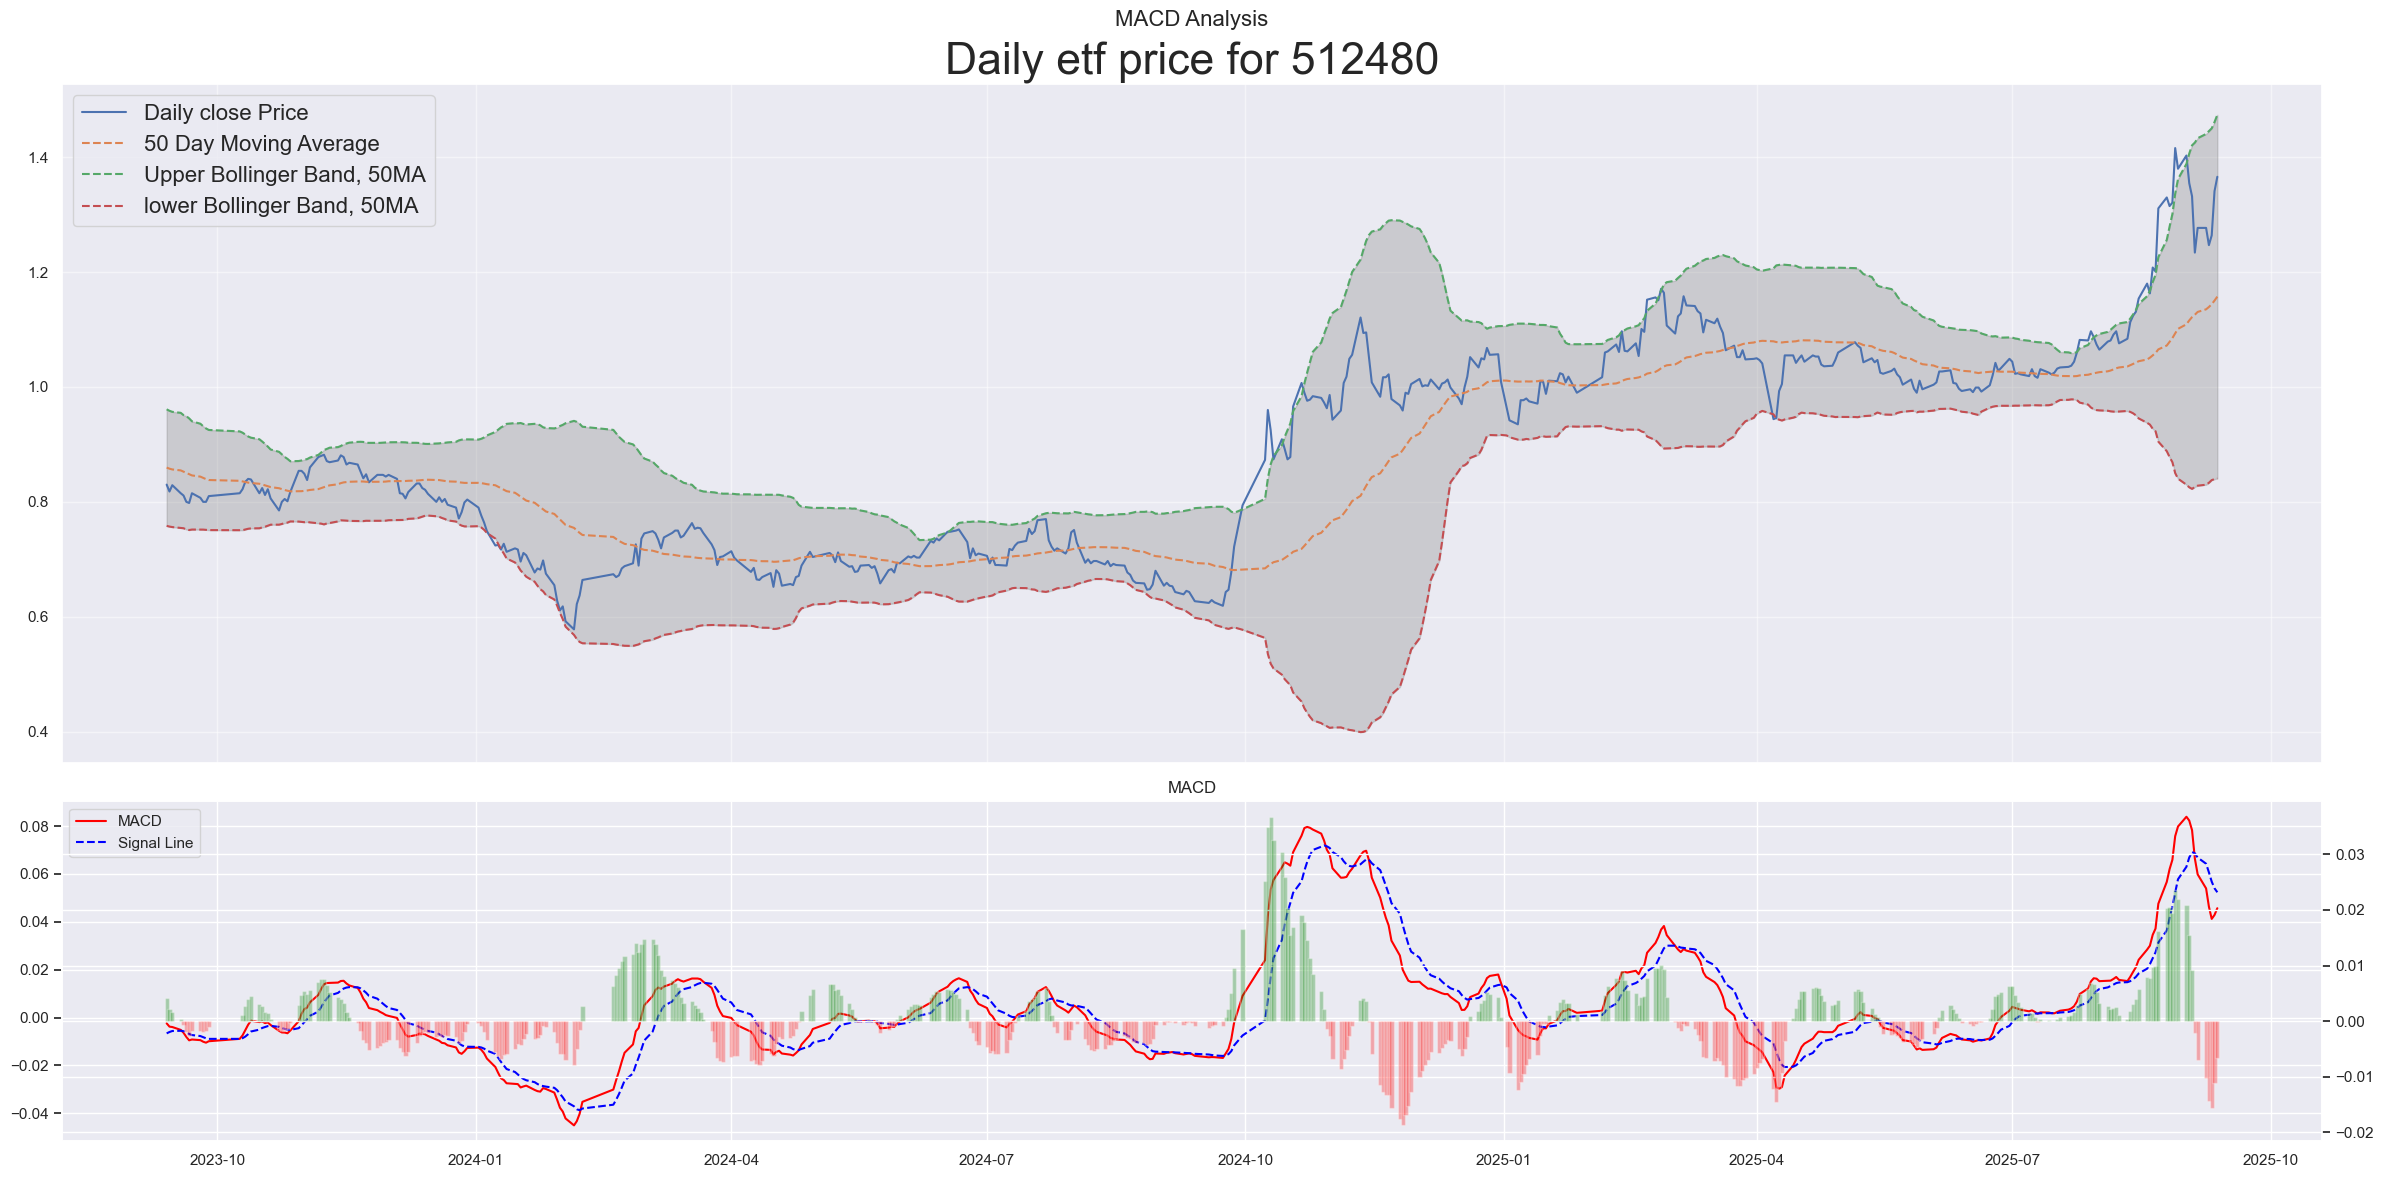

In [12]:
# 半导体
etf_code = "512480"
etf_strategy(etf_code).output()

* Current etf price: 1.18
* Recent high: 1.2
* Current etf price is at 97.92% of recent high
Latest 20 Day MA: 1.09
Latest lower Bollinger Band, 20MA: 0.97
Latest higher Bollinger Band, 20MA: 1.21
Latest 50 Day MA: 1.03
Latest lower Bollinger Band, 50MA: 0.86
Latest higher Bollinger Band, 50MA: 1.19
Latest 50 Day EMA: 1.04
Latest 120 Day MA: 0.96
Latest 200 Day MA: 0.97
Latest 200 Day EMA: 0.98
Latest 10 Week MA: 1.04
Latest 20 Week MA: 0.98
Latest 30 Week MA: 0.96
Latest 40 Week MA: 0.96
Latest Lower Weekly Bollinger Band, 20MA: 0.8
Latest Higher Weekly Bollinger Band, 20MA: 1.15

Latest RSI: 76.95 
Latest MACD Divergence: 0.0097 
20MA break point: 1.09
20MA lower Bollinger Band break point: 0.95
20MA Upper Bollinger Band break point: 1.23
50MA break point: 1.03
50MA lower Bollinger Band break point: 0.85
50MA Upper Bollinger Band break point: 1.2
120MA break point: 0.96
200MA break point: 0.97


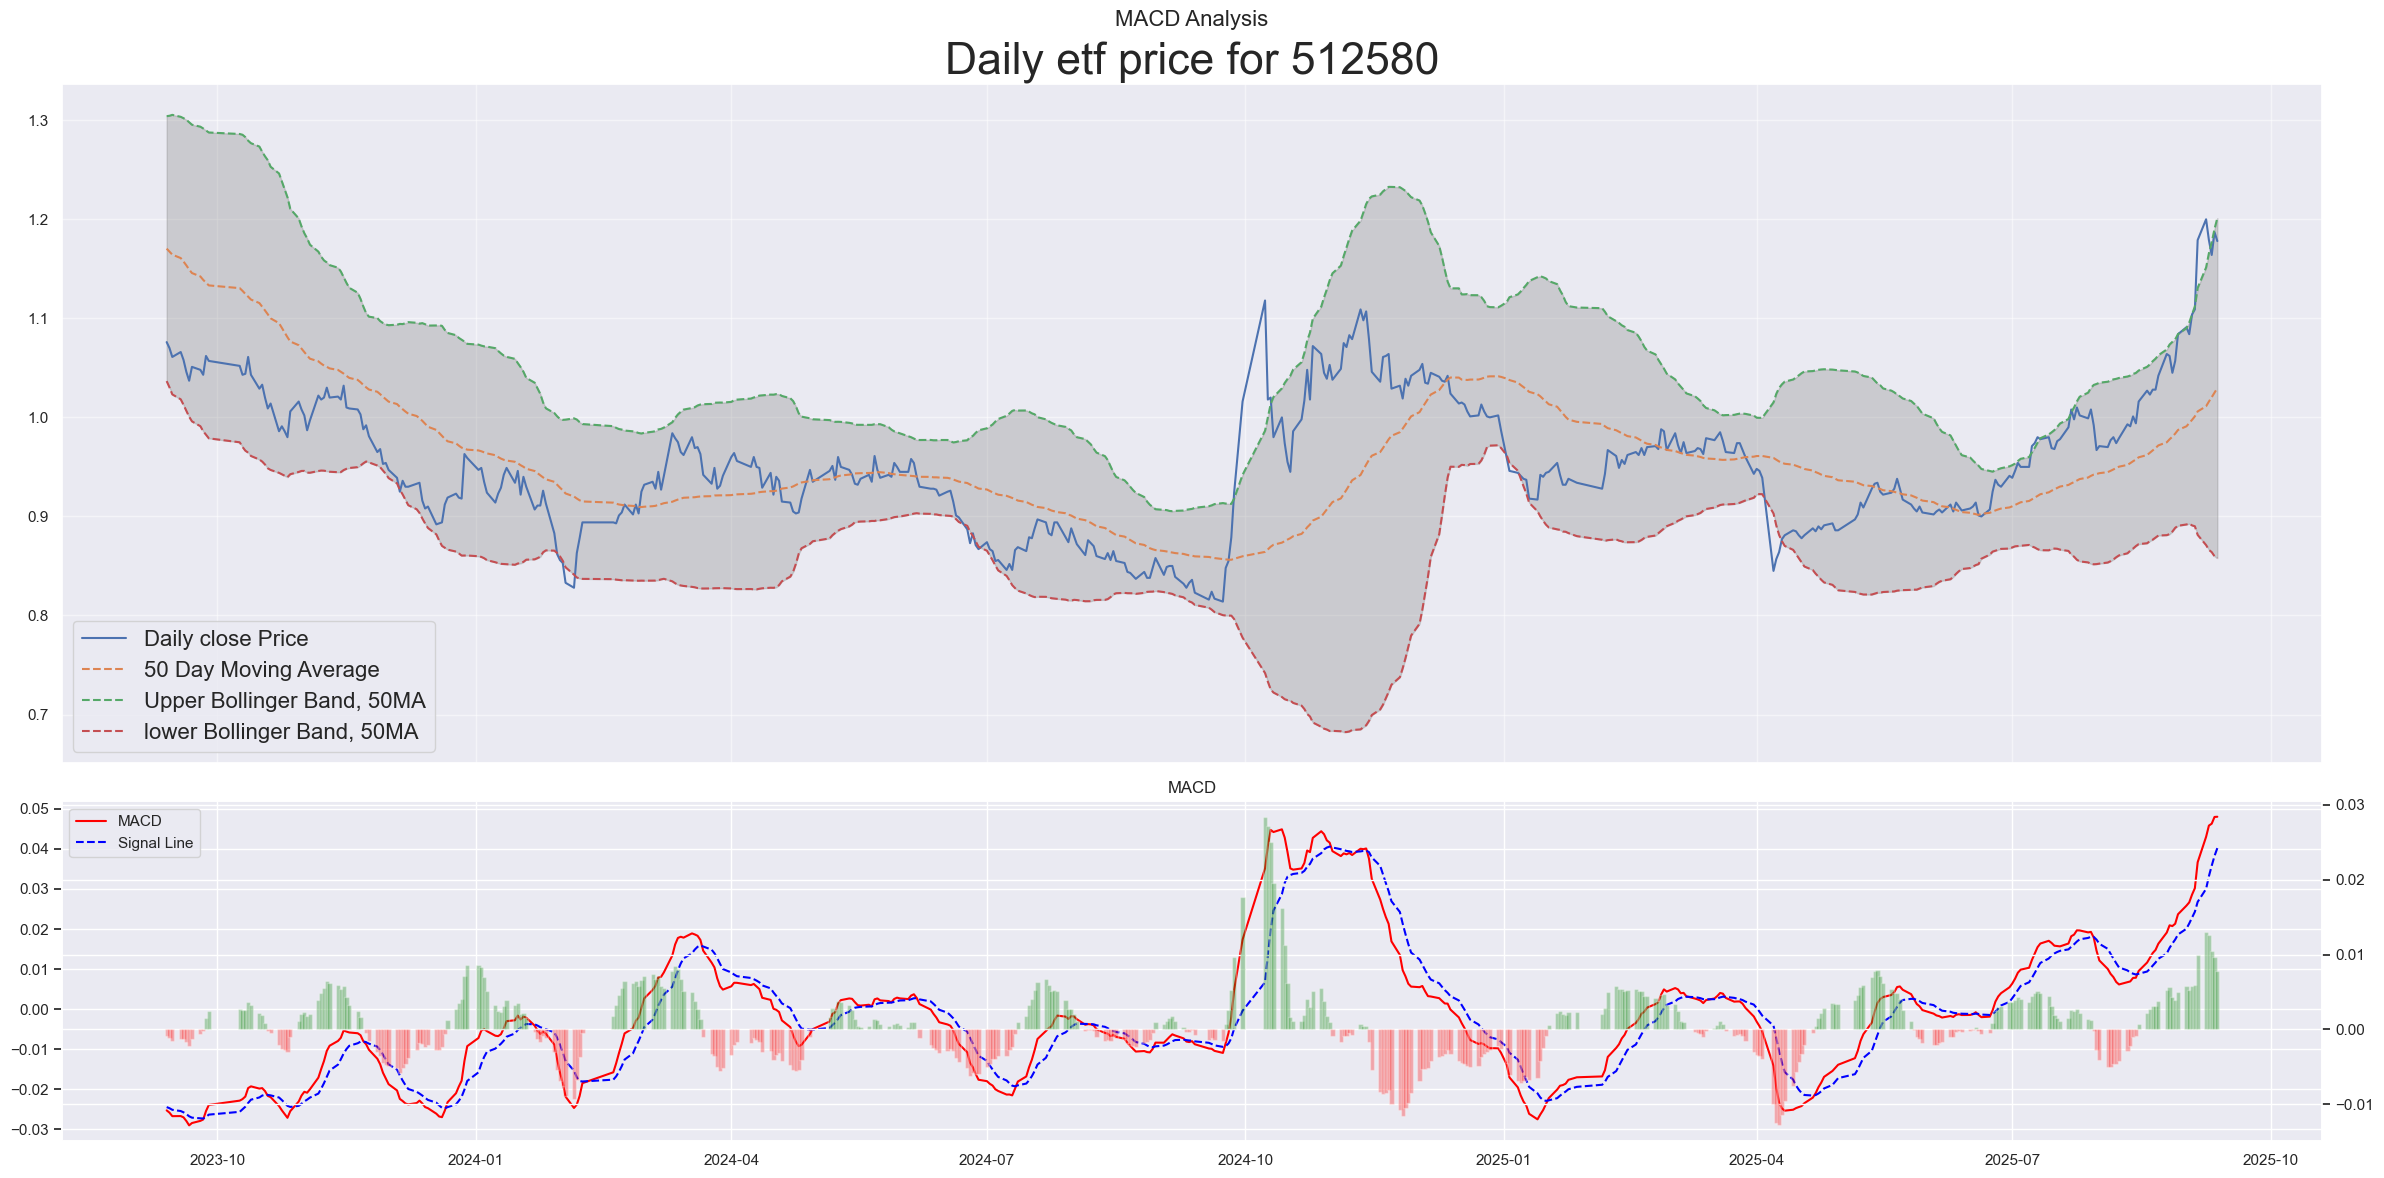

In [13]:
# 环保
etf_code = "512580"
etf_strategy(etf_code).output()

* Current etf price: 3.33
* Recent high: 3.37
* Current etf price is at 98.78% of recent high
Latest 20 Day MA: 3.08
Latest lower Bollinger Band, 20MA: 2.75
Latest higher Bollinger Band, 20MA: 3.4
Latest 50 Day MA: 2.75
Latest lower Bollinger Band, 50MA: 2.01
Latest higher Bollinger Band, 50MA: 3.49
Latest 50 Day EMA: 2.82
Latest 120 Day MA: 2.44
Latest 200 Day MA: 2.41
Latest 200 Day EMA: 2.45
Latest 10 Week MA: 2.82
Latest 20 Week MA: 2.53
Latest 30 Week MA: 2.45
Latest 40 Week MA: 2.42
Latest Lower Weekly Bollinger Band, 20MA: 1.77
Latest Higher Weekly Bollinger Band, 20MA: 3.29

Latest RSI: 68.29 
Latest MACD Divergence: 0.0033 
20MA break point: 3.09
20MA lower Bollinger Band break point: 2.73
20MA Upper Bollinger Band break point: 3.45
50MA break point: 2.76
50MA lower Bollinger Band break point: 1.97
50MA Upper Bollinger Band break point: 3.55
120MA break point: 2.44
200MA break point: 2.41


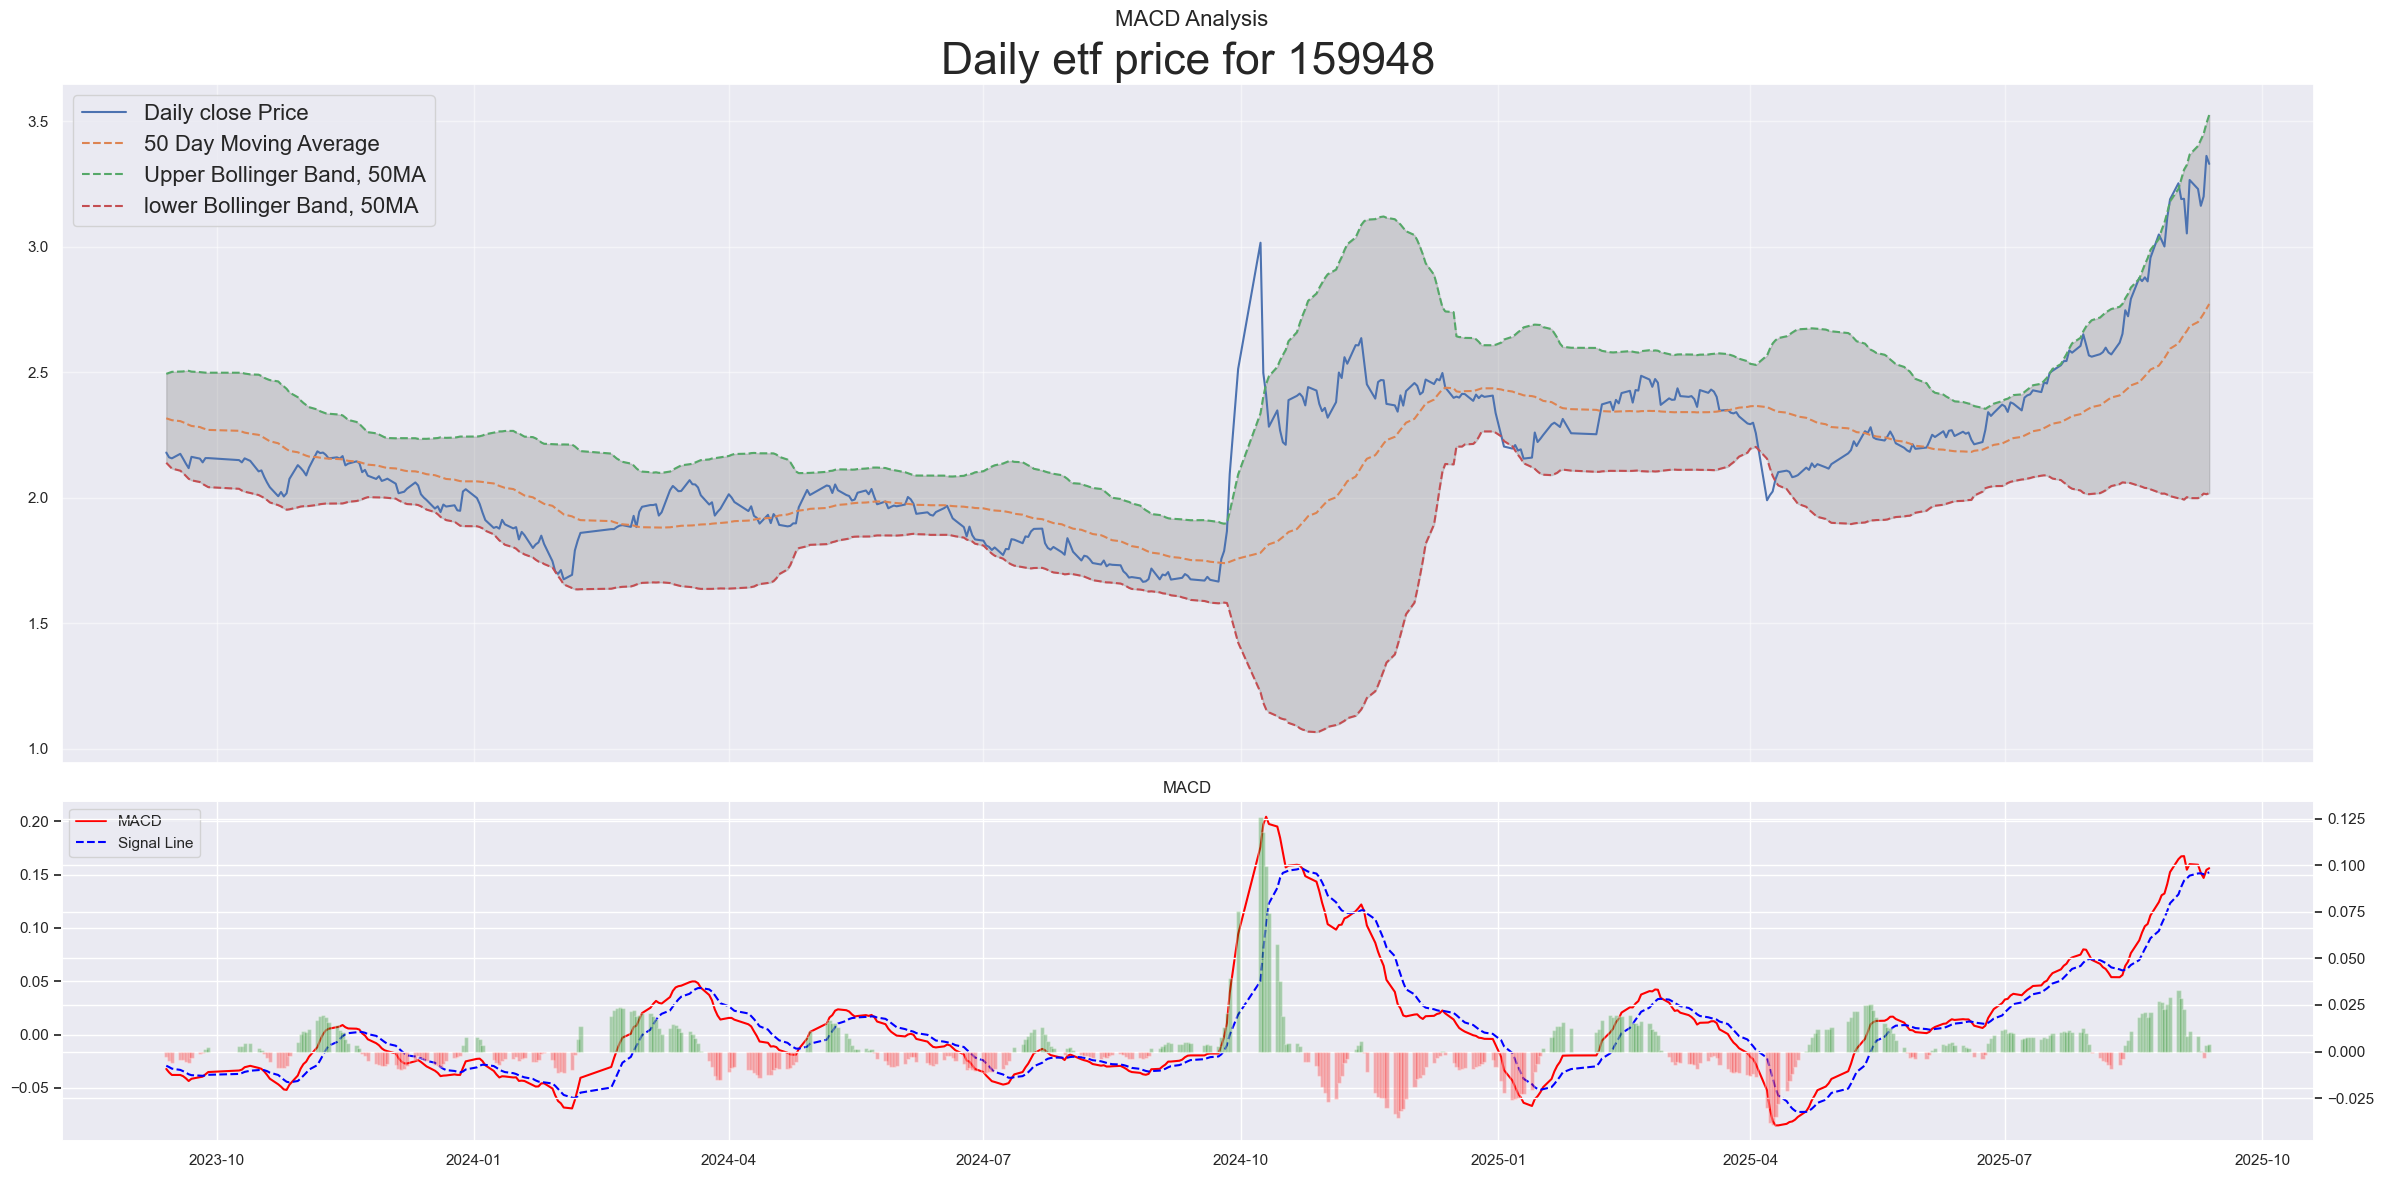

In [14]:
# 创业板
etf_code = "159948"
etf_strategy(etf_code).output()

* Current etf price: 1.04
* Recent high: 1.06
* Current etf price is at 98.2% of recent high
Latest 20 Day MA: 1.01
Latest lower Bollinger Band, 20MA: 0.96
Latest higher Bollinger Band, 20MA: 1.05
Latest 50 Day MA: 0.94
Latest lower Bollinger Band, 50MA: 0.77
Latest higher Bollinger Band, 50MA: 1.11
Latest 50 Day EMA: 0.95
Latest 120 Day MA: 0.88
Latest 200 Day MA: 0.88
Latest 200 Day EMA: 0.87
Latest 10 Week MA: 0.95
Latest 20 Week MA: 0.89
Latest 30 Week MA: 0.9
Latest 40 Week MA: 0.88
Latest Lower Weekly Bollinger Band, 20MA: 0.75
Latest Higher Weekly Bollinger Band, 20MA: 1.04

Latest RSI: 57.92 
Latest MACD Divergence: -0.0017 
20MA break point: 1.01
20MA lower Bollinger Band break point: 0.96
20MA Upper Bollinger Band break point: 1.06
50MA break point: 0.94
50MA lower Bollinger Band break point: 0.76
50MA Upper Bollinger Band break point: 1.12
120MA break point: 0.88
200MA break point: 0.88


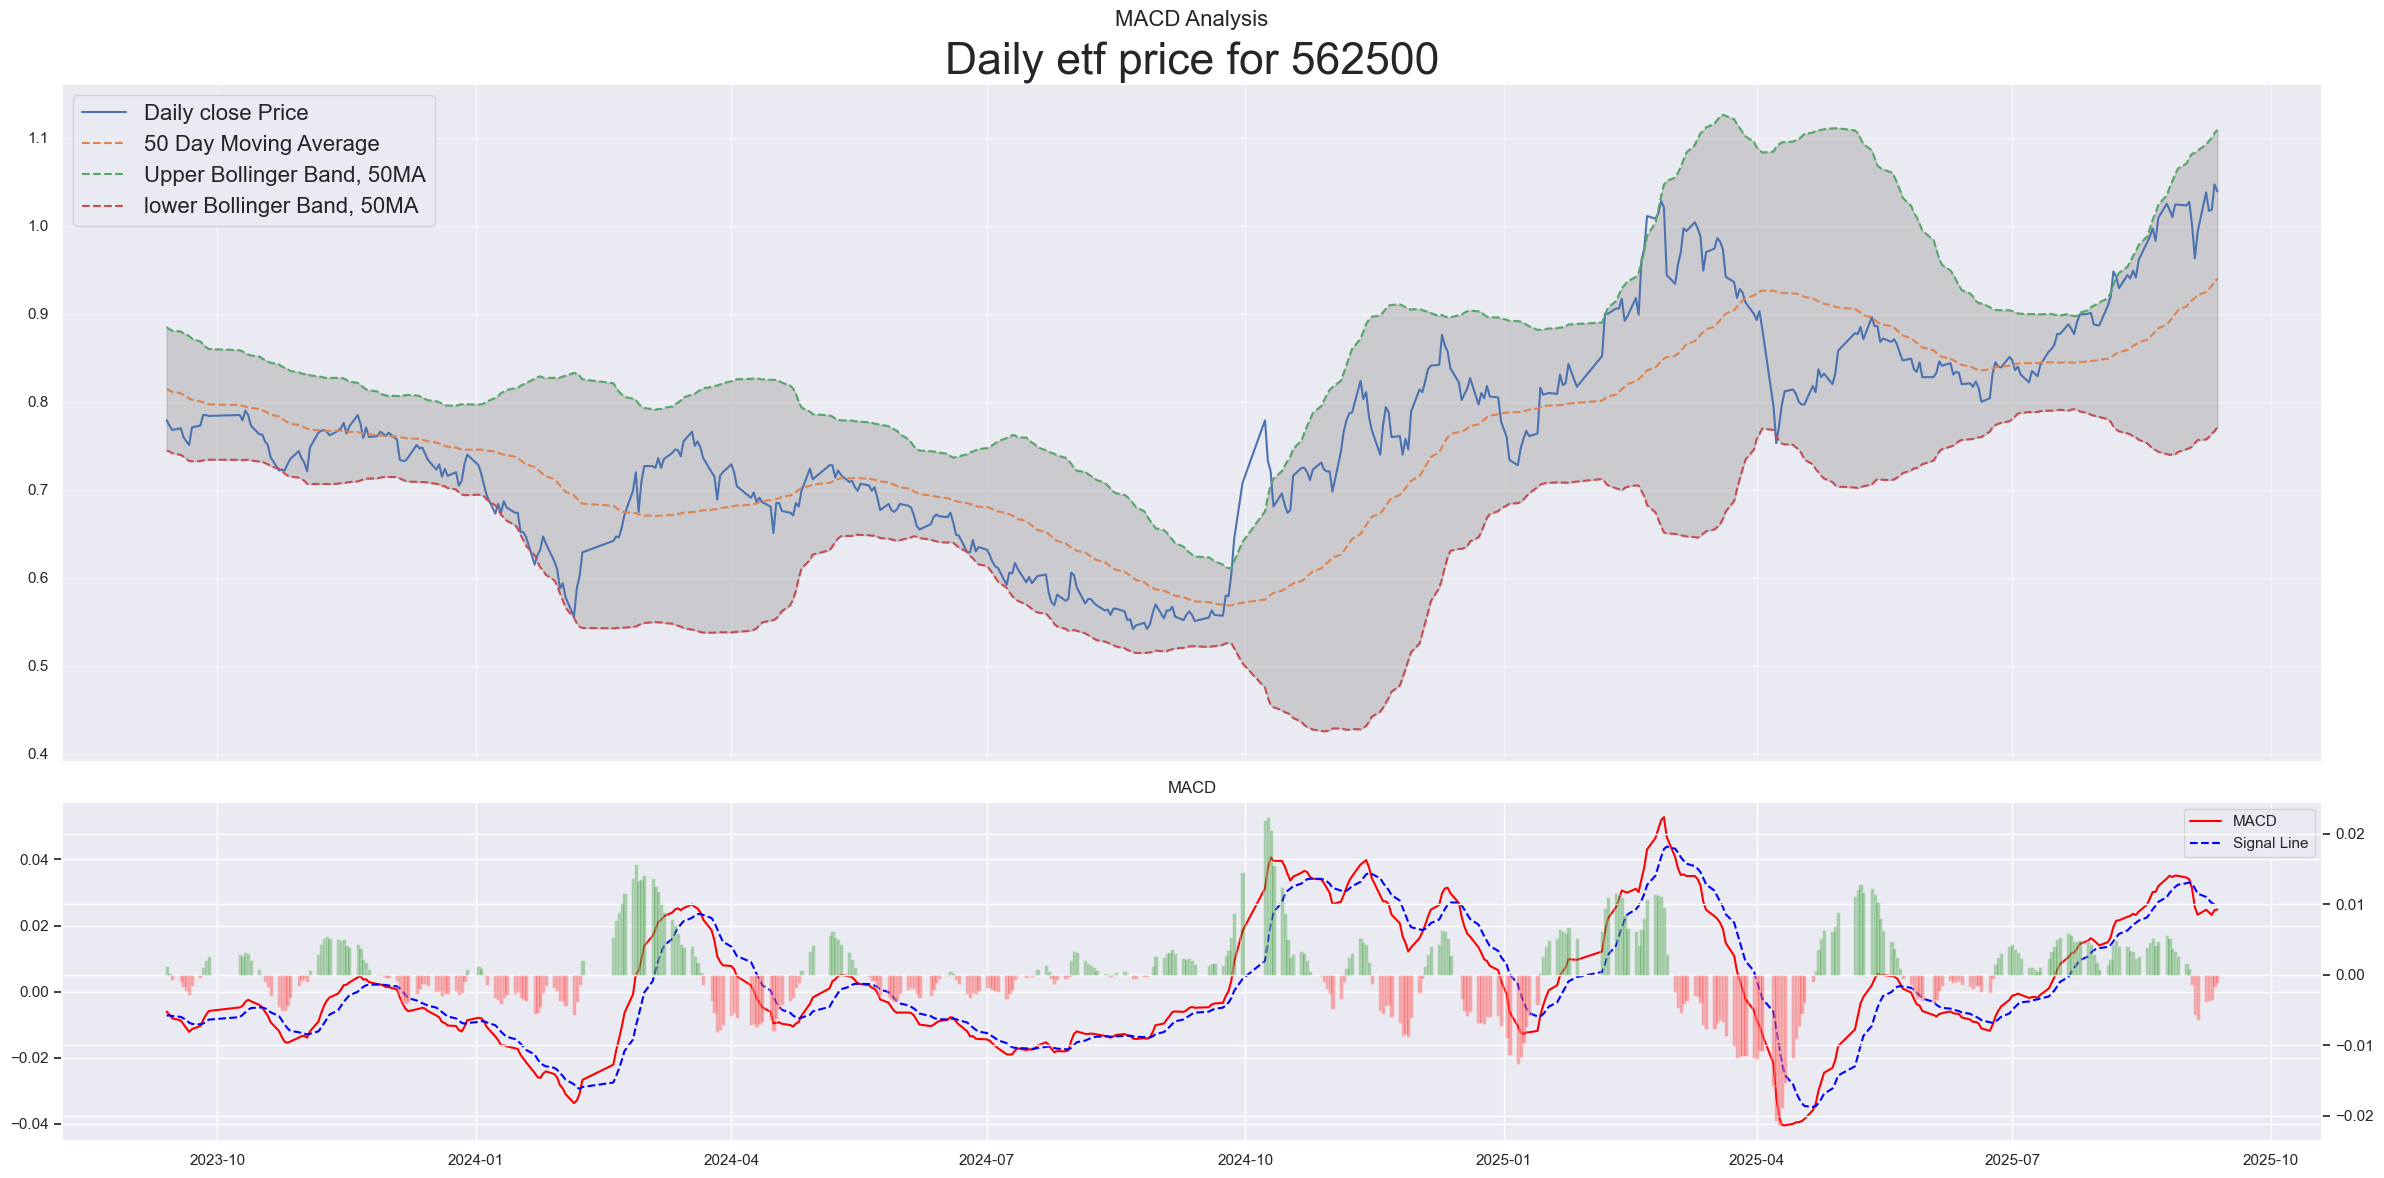

In [15]:
# 机器人
etf_code = "562500"
etf_strategy(etf_code).output()

* Current etf price: 1.47
* Recent high: 1.51
* Current etf price is at 97.22% of recent high
Latest 20 Day MA: 1.35
Latest lower Bollinger Band, 20MA: 1.15
Latest higher Bollinger Band, 20MA: 1.55
Latest 50 Day MA: 1.16
Latest lower Bollinger Band, 50MA: 0.72
Latest higher Bollinger Band, 50MA: 1.59
Latest 50 Day EMA: 1.21
Latest 120 Day MA: 1.02
Latest 200 Day MA: 0.99
Latest 200 Day EMA: 1.01
Latest 10 Week MA: 1.19
Latest 20 Week MA: 1.06
Latest 30 Week MA: 1.03
Latest 40 Week MA: 1.0
Latest Lower Weekly Bollinger Band, 20MA: 0.67
Latest Higher Weekly Bollinger Band, 20MA: 1.44

Latest RSI: 60.29 
Latest MACD Divergence: -0.0093 
20MA break point: 1.36
20MA lower Bollinger Band break point: 1.14
20MA Upper Bollinger Band break point: 1.57
50MA break point: 1.16
50MA lower Bollinger Band break point: 0.69
50MA Upper Bollinger Band break point: 1.63
120MA break point: 1.02
200MA break point: 0.99


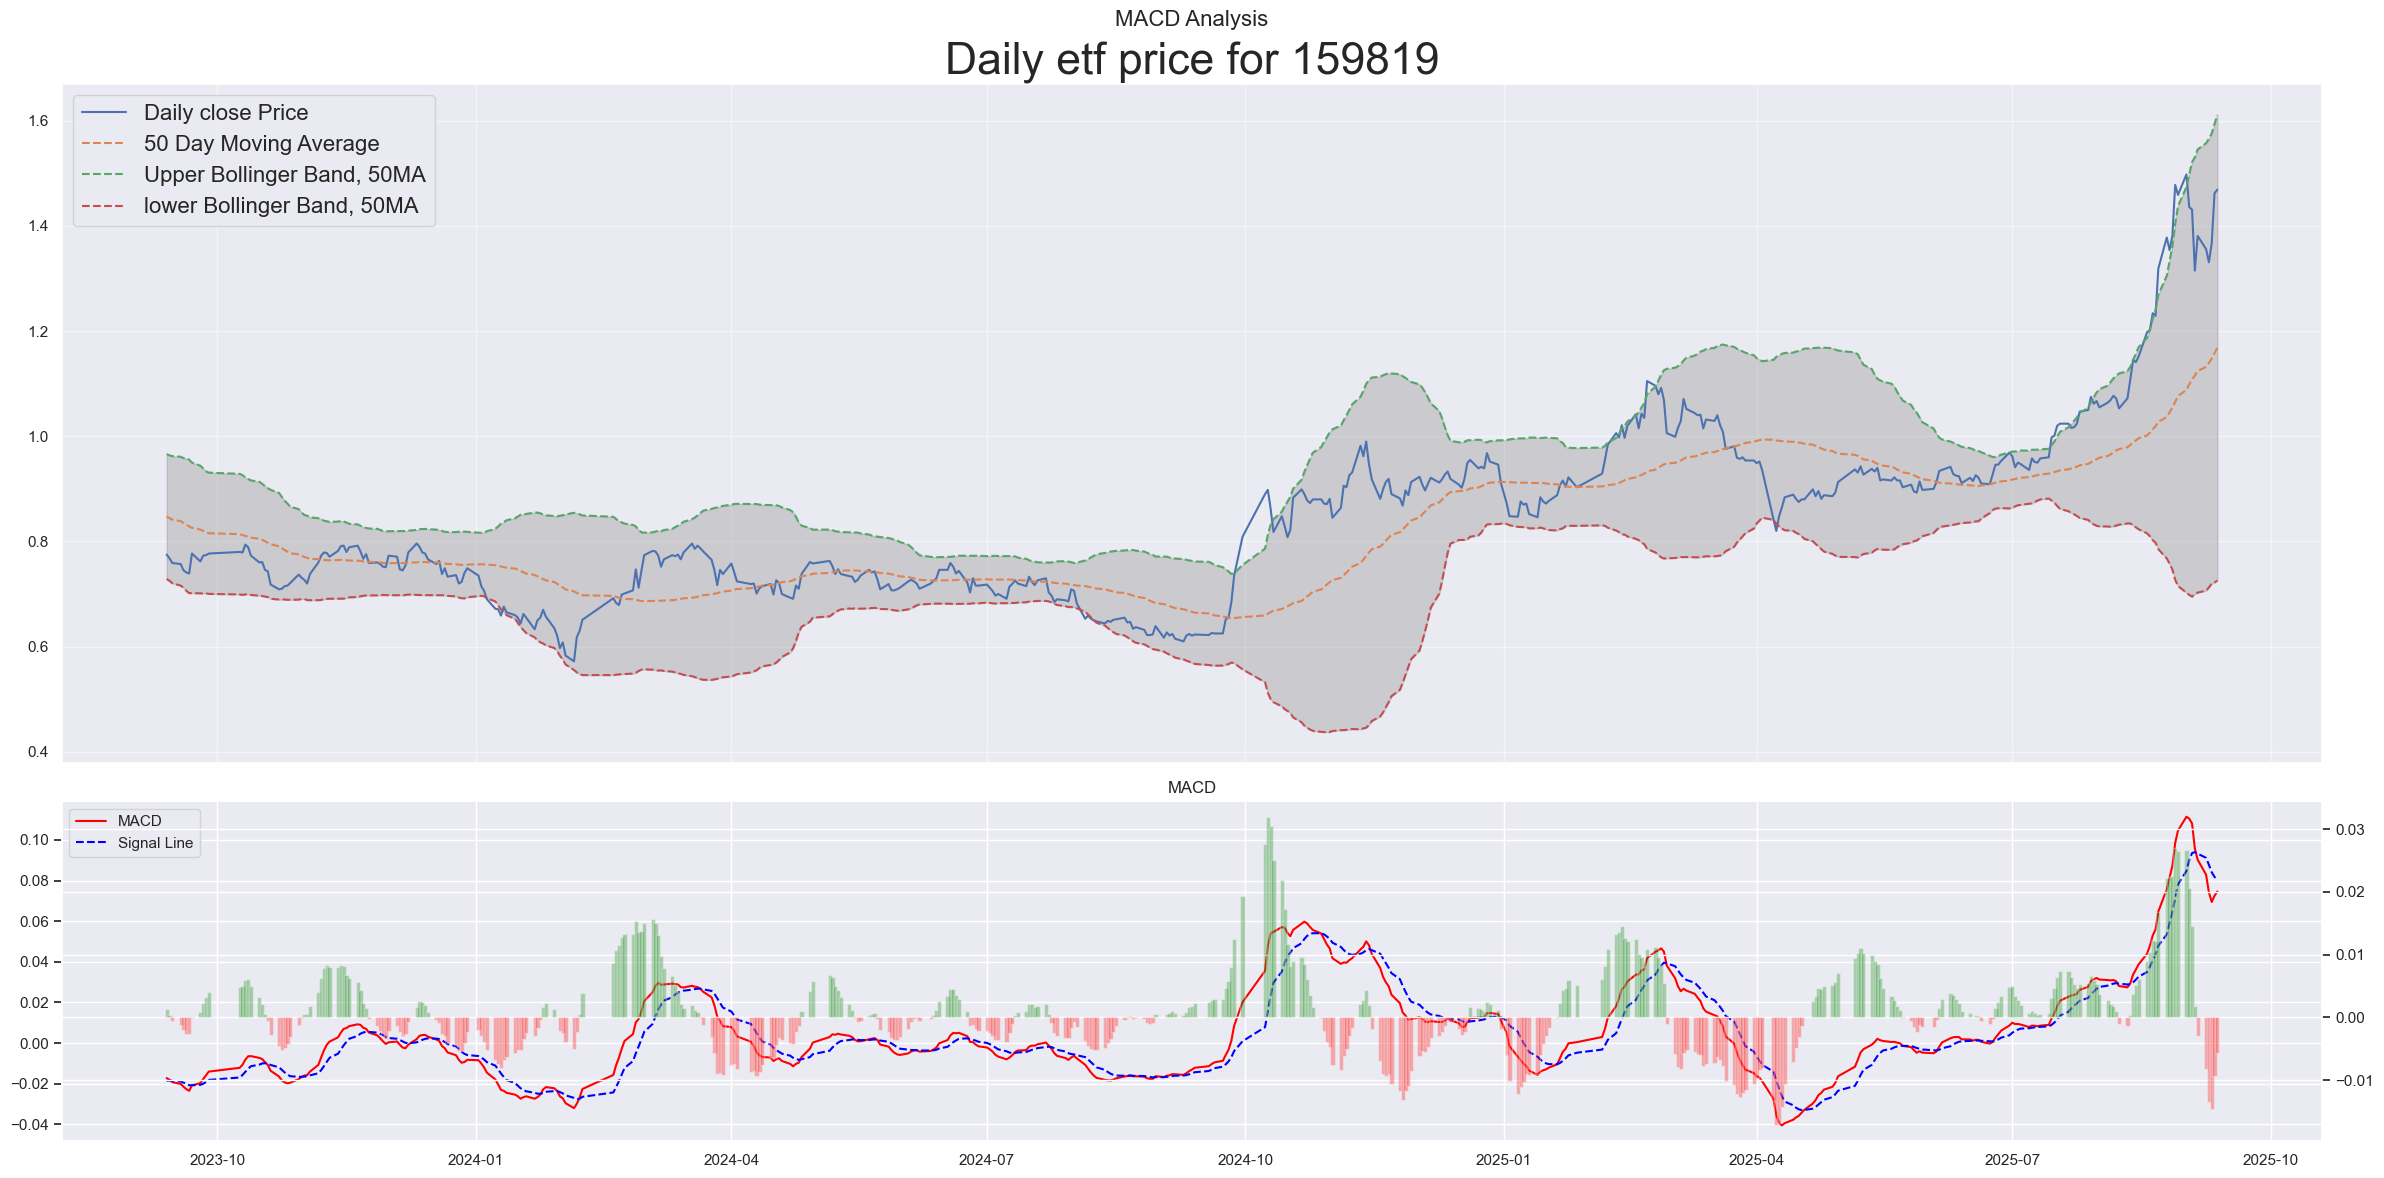

In [16]:
# 人工智能
etf_code = "159819"
etf_strategy(etf_code).output()

* Current etf price: 0.75
* Recent high: 1.01
* Current etf price is at 73.69% of recent high
Latest 20 Day MA: 0.73
Latest lower Bollinger Band, 20MA: 0.7
Latest higher Bollinger Band, 20MA: 0.77
Latest 50 Day MA: 0.71
Latest lower Bollinger Band, 50MA: 0.65
Latest higher Bollinger Band, 50MA: 0.77
Latest 50 Day EMA: 0.72
Latest 120 Day MA: 0.7
Latest 200 Day MA: 0.69
Latest 200 Day EMA: 0.7
Latest 10 Week MA: 0.71
Latest 20 Week MA: 0.7
Latest 30 Week MA: 0.7
Latest 40 Week MA: 0.69
Latest Lower Weekly Bollinger Band, 20MA: 0.66
Latest Higher Weekly Bollinger Band, 20MA: 0.74

Latest RSI: 63.03 
Latest MACD Divergence: 0.0007 
20MA break point: 0.74
20MA lower Bollinger Band break point: 0.7
20MA Upper Bollinger Band break point: 0.77
50MA break point: 0.71
50MA lower Bollinger Band break point: 0.64
50MA Upper Bollinger Band break point: 0.77
120MA break point: 0.7
200MA break point: 0.69


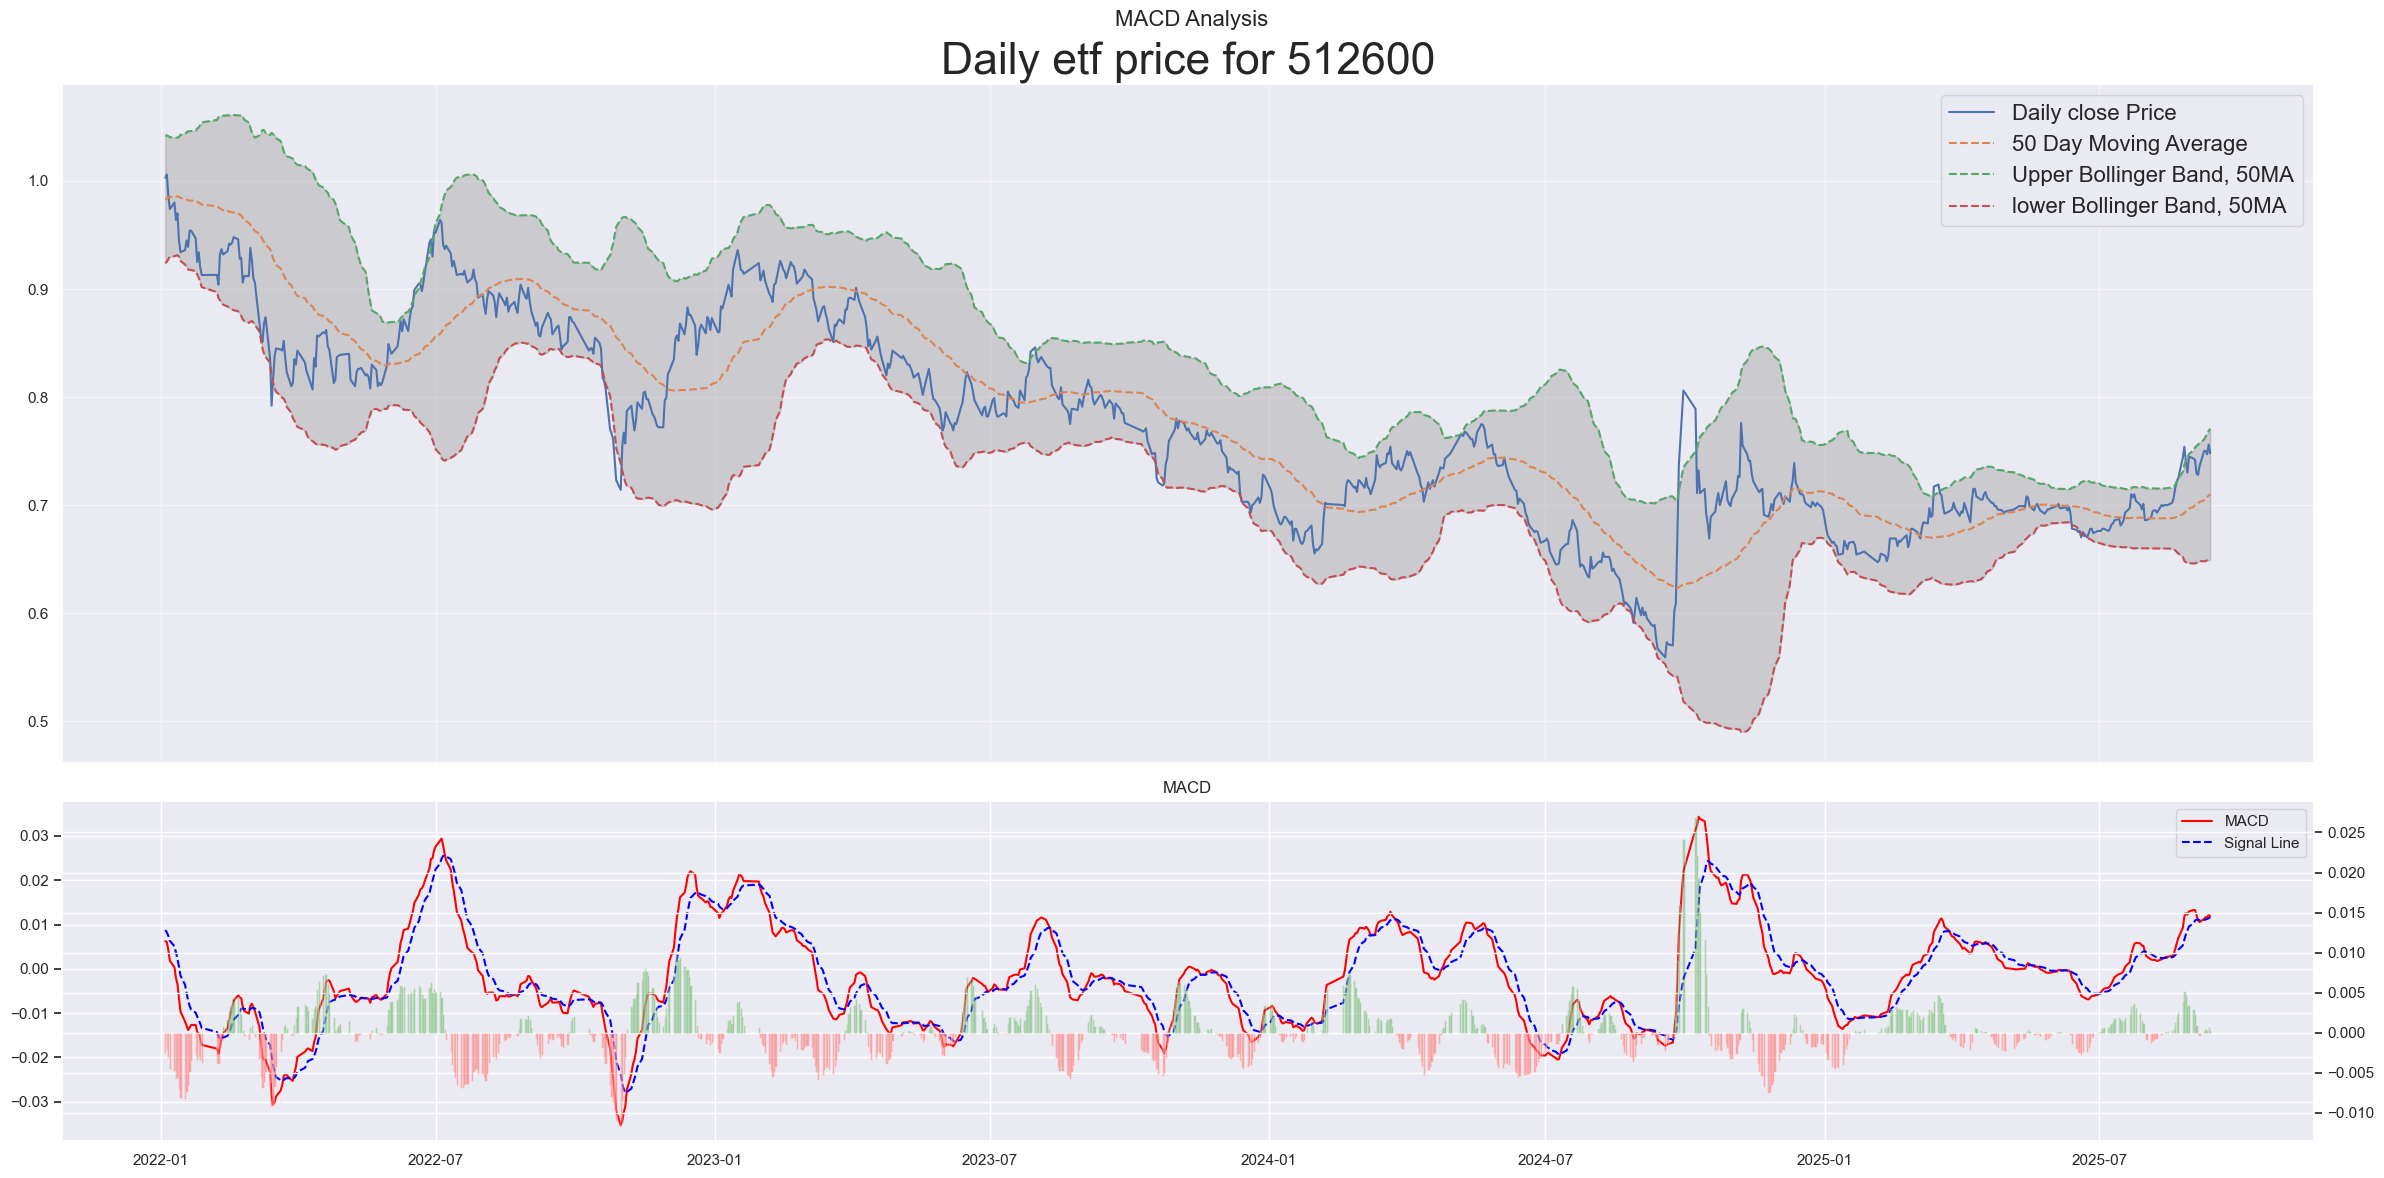

In [17]:
# 必选消费
etf_code = "512600"
etf_strategy(etf_code, start='20210101').output()

* Current etf price: 1.57
* Recent high: 1.62
* Current etf price is at 96.55% of recent high
Latest 20 Day MA: 1.56
Latest lower Bollinger Band, 20MA: 1.51
Latest higher Bollinger Band, 20MA: 1.61
Latest 50 Day MA: 1.49
Latest lower Bollinger Band, 50MA: 1.33
Latest higher Bollinger Band, 50MA: 1.65
Latest 50 Day EMA: 1.51
Latest 120 Day MA: 1.43
Latest 200 Day MA: 1.42
Latest 200 Day EMA: 1.41
Latest 10 Week MA: 1.5
Latest 20 Week MA: 1.44
Latest 30 Week MA: 1.43
Latest 40 Week MA: 1.42
Latest Lower Weekly Bollinger Band, 20MA: 1.29
Latest Higher Weekly Bollinger Band, 20MA: 1.59

Latest RSI: 52.92 
Latest MACD Divergence: -0.0049 
20MA break point: 1.57
20MA lower Bollinger Band break point: 1.51
20MA Upper Bollinger Band break point: 1.62
50MA break point: 1.49
50MA lower Bollinger Band break point: 1.32
50MA Upper Bollinger Band break point: 1.67
120MA break point: 1.43
200MA break point: 1.42


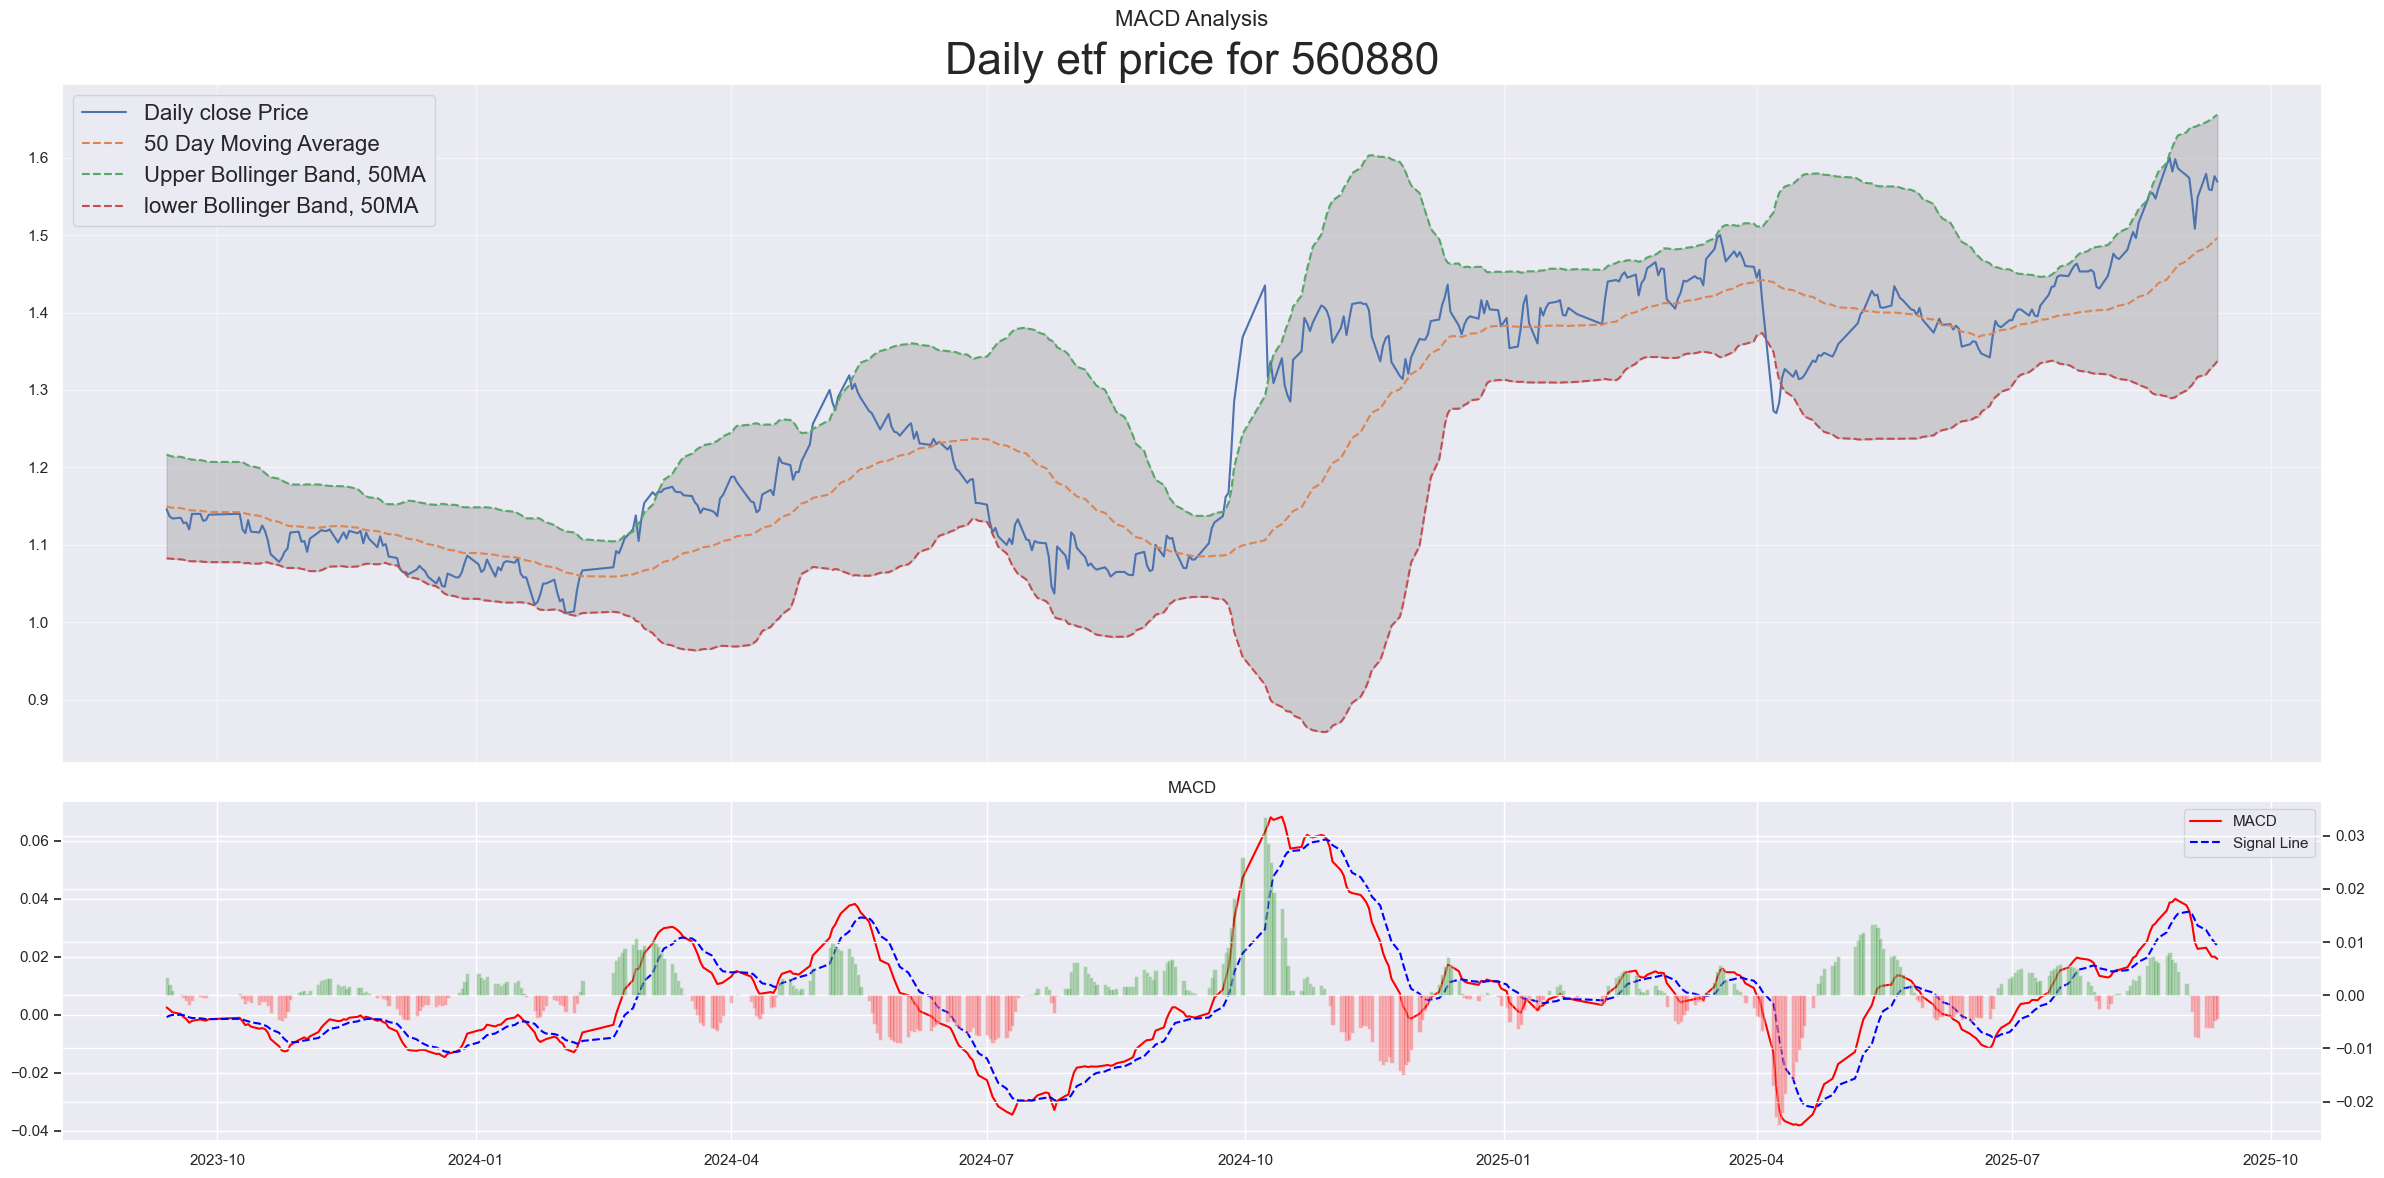

In [18]:
# 家电
etf_code = "560880"
etf_strategy(etf_code).output()

* Current etf price: 1.56
* Recent high: 1.58
* Current etf price is at 98.99% of recent high
Latest 20 Day MA: 1.44
Latest lower Bollinger Band, 20MA: 1.31
Latest higher Bollinger Band, 20MA: 1.58
Latest 50 Day MA: 1.32
Latest lower Bollinger Band, 50MA: 1.01
Latest higher Bollinger Band, 50MA: 1.63
Latest 50 Day EMA: 1.34
Latest 120 Day MA: 1.17
Latest 200 Day MA: 1.12
Latest 200 Day EMA: 1.16
Latest 10 Week MA: 1.34
Latest 20 Week MA: 1.21
Latest 30 Week MA: 1.16
Latest 40 Week MA: 1.12
Latest Lower Weekly Bollinger Band, 20MA: 0.88
Latest Higher Weekly Bollinger Band, 20MA: 1.55

Latest RSI: 68.22 
Latest MACD Divergence: -0.0007 
20MA break point: 1.45
20MA lower Bollinger Band break point: 1.29
20MA Upper Bollinger Band break point: 1.61
50MA break point: 1.32
50MA lower Bollinger Band break point: 0.99
50MA Upper Bollinger Band break point: 1.65
120MA break point: 1.17
200MA break point: 1.12


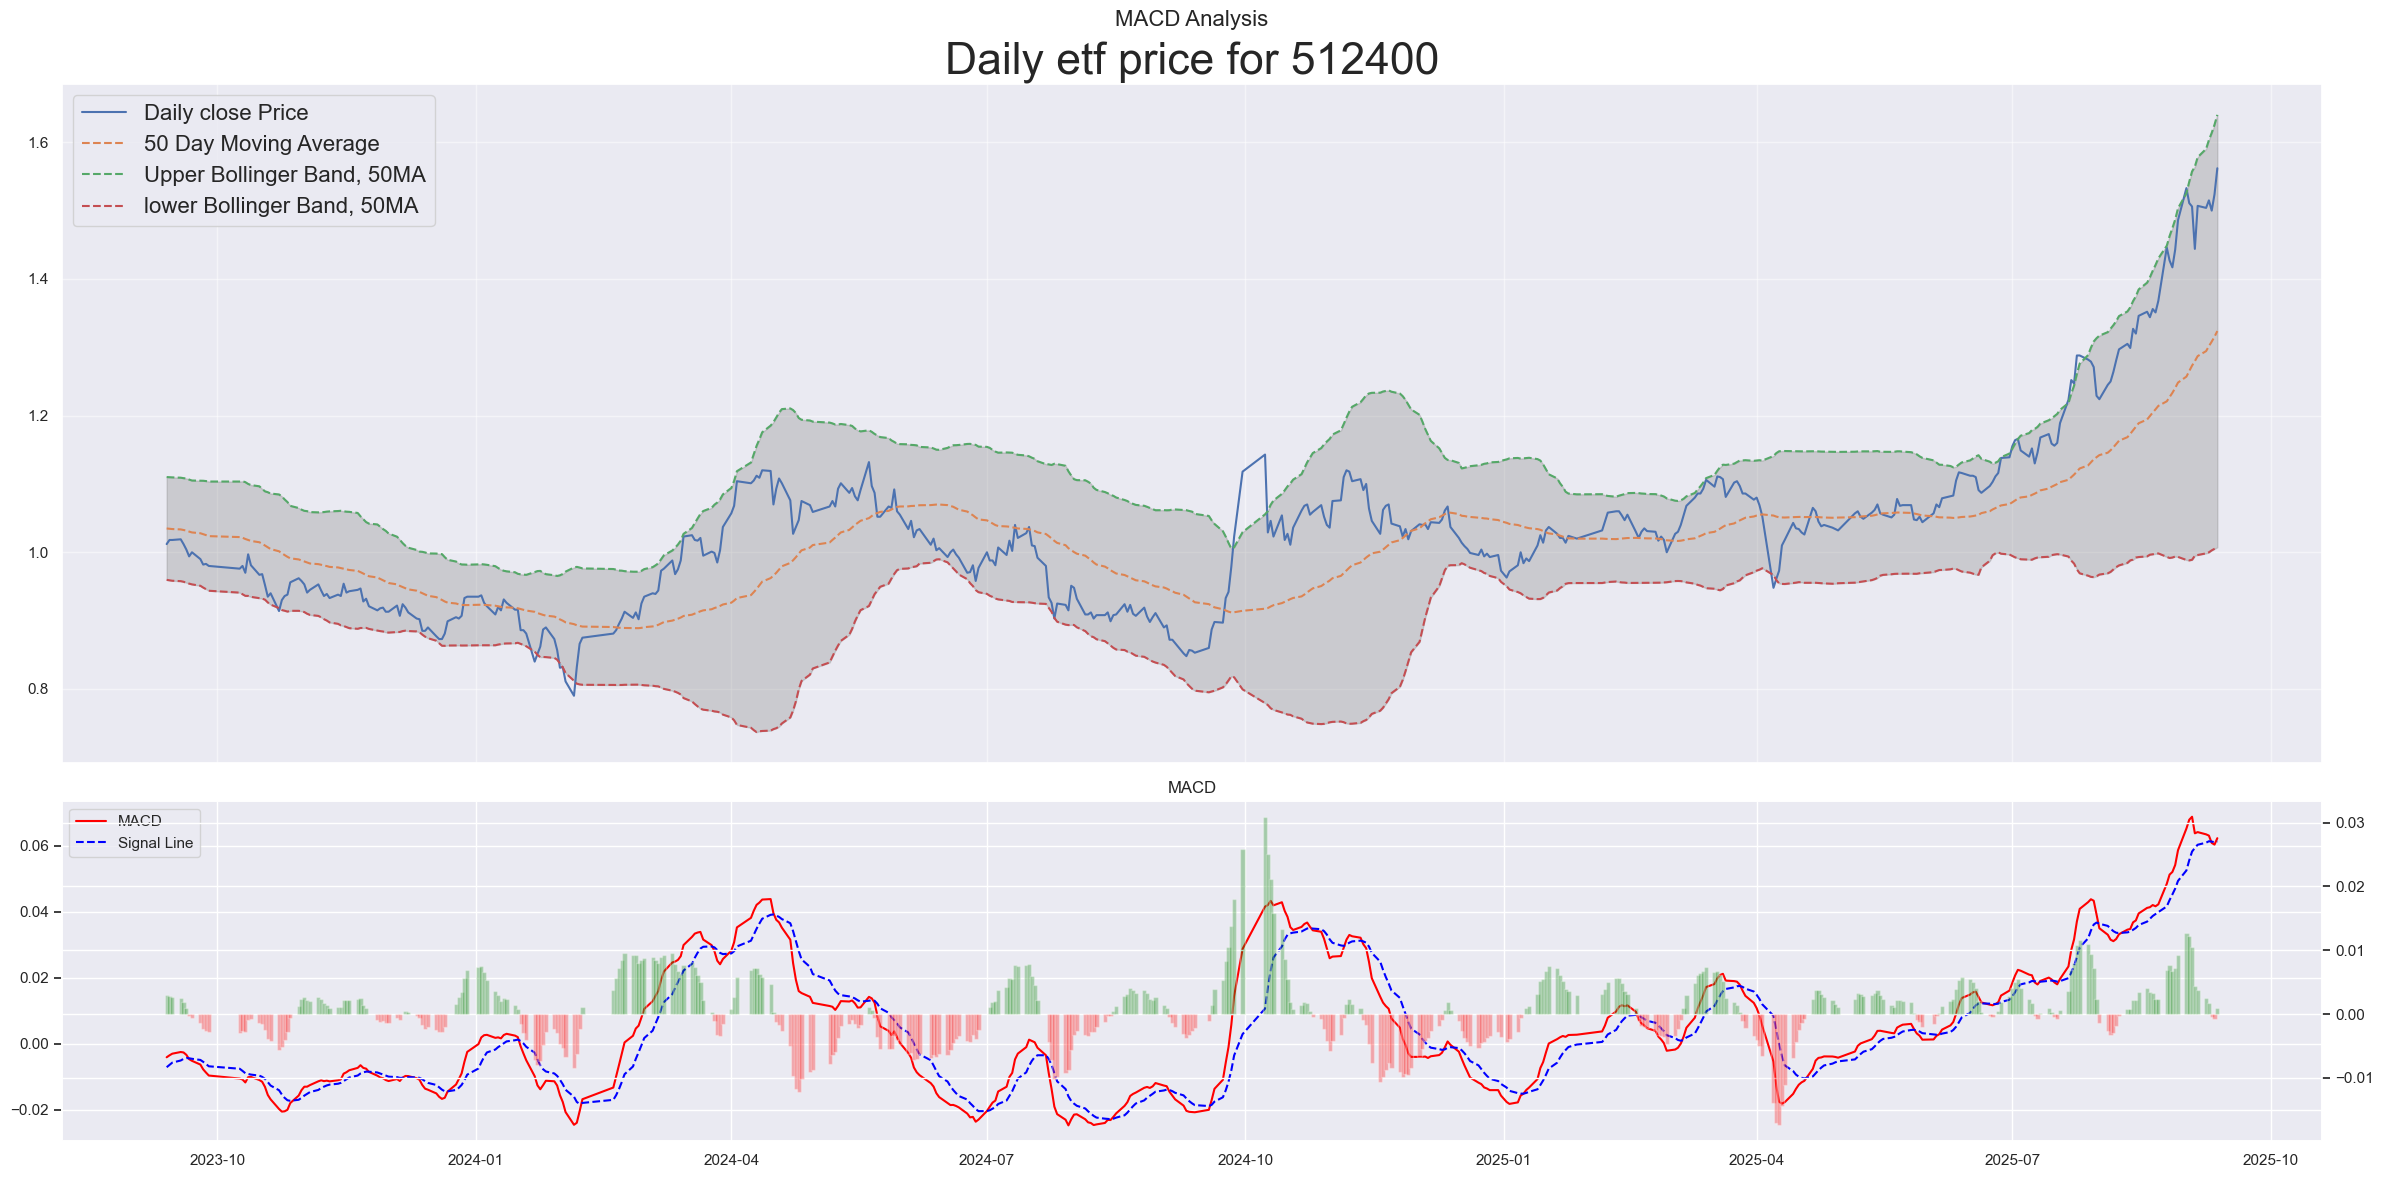

In [19]:
# 有色金属
etf_code = "512400"
etf_strategy(etf_code).output()

* Current etf price: 1.06
* Recent high: 1.2
* Current etf price is at 88.14% of recent high
Latest 20 Day MA: 1.04
Latest lower Bollinger Band, 20MA: 1.03
Latest higher Bollinger Band, 20MA: 1.06
Latest 50 Day MA: 1.03
Latest lower Bollinger Band, 50MA: 0.99
Latest higher Bollinger Band, 50MA: 1.07
Latest 50 Day EMA: 1.03
Latest 120 Day MA: 1.0
Latest 200 Day MA: 1.01
Latest 200 Day EMA: 1.01
Latest 10 Week MA: 1.03
Latest 20 Week MA: 1.01
Latest 30 Week MA: 1.0
Latest 40 Week MA: 1.0
Latest Lower Weekly Bollinger Band, 20MA: 0.94
Latest Higher Weekly Bollinger Band, 20MA: 1.08

Latest RSI: 52.59 
Latest MACD Divergence: 0.0004 
20MA crosses 50MA at 0.67
20MA break point: 1.04
20MA lower Bollinger Band break point: 1.02
20MA Upper Bollinger Band break point: 1.07
50MA break point: 1.03
50MA lower Bollinger Band break point: 0.99
50MA Upper Bollinger Band break point: 1.07
120MA break point: 1.0
200MA break point: 1.01


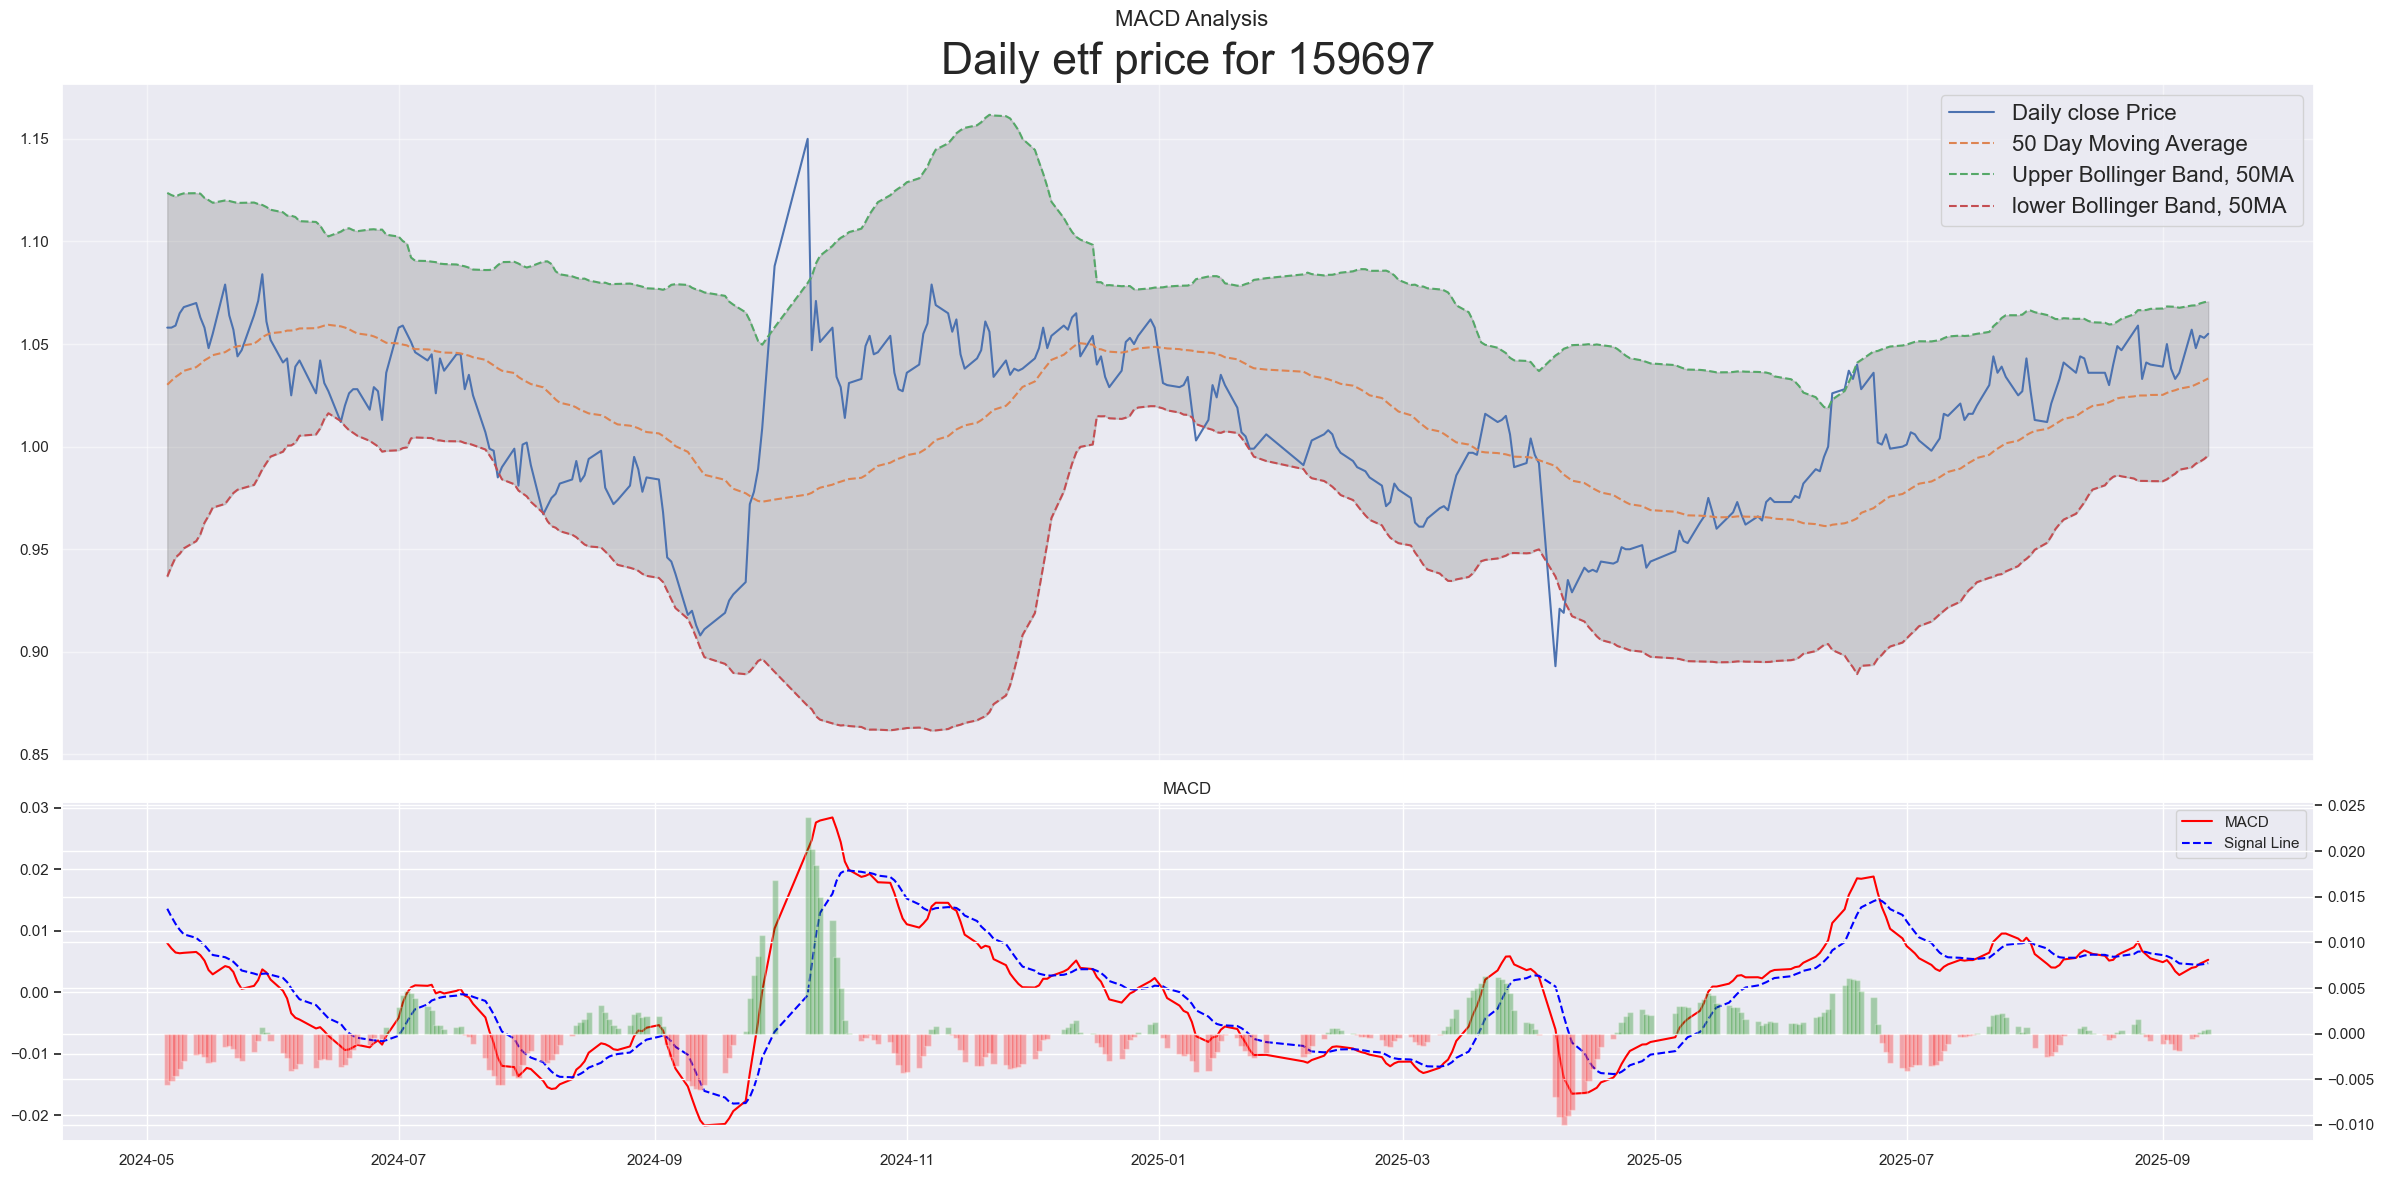

In [20]:
# 油气
etf_code = "159697"
etf_strategy(etf_code).output()

* Current etf price: 2.62
* Recent high: 2.76
* Current etf price is at 94.93% of recent high
Latest 20 Day MA: 2.36
Latest lower Bollinger Band, 20MA: 1.91
Latest higher Bollinger Band, 20MA: 2.8
Latest 50 Day MA: 1.94
Latest lower Bollinger Band, 50MA: 0.97
Latest higher Bollinger Band, 50MA: 2.91
Latest 50 Day EMA: 2.03
Latest 120 Day MA: 1.54
Latest 200 Day MA: 1.47
Latest 200 Day EMA: 1.56
Latest 10 Week MA: 2.0
Latest 20 Week MA: 1.65
Latest 30 Week MA: 1.52
Latest 40 Week MA: 1.48
Latest Lower Weekly Bollinger Band, 20MA: 0.7
Latest Higher Weekly Bollinger Band, 20MA: 2.6

Latest RSI: 64.68 
Latest MACD Divergence: -0.0103 
20MA break point: 2.38
20MA lower Bollinger Band break point: 1.9
20MA Upper Bollinger Band break point: 2.86
50MA break point: 1.95
50MA lower Bollinger Band break point: 0.91
50MA Upper Bollinger Band break point: 2.99
120MA break point: 1.54
200MA break point: 1.47


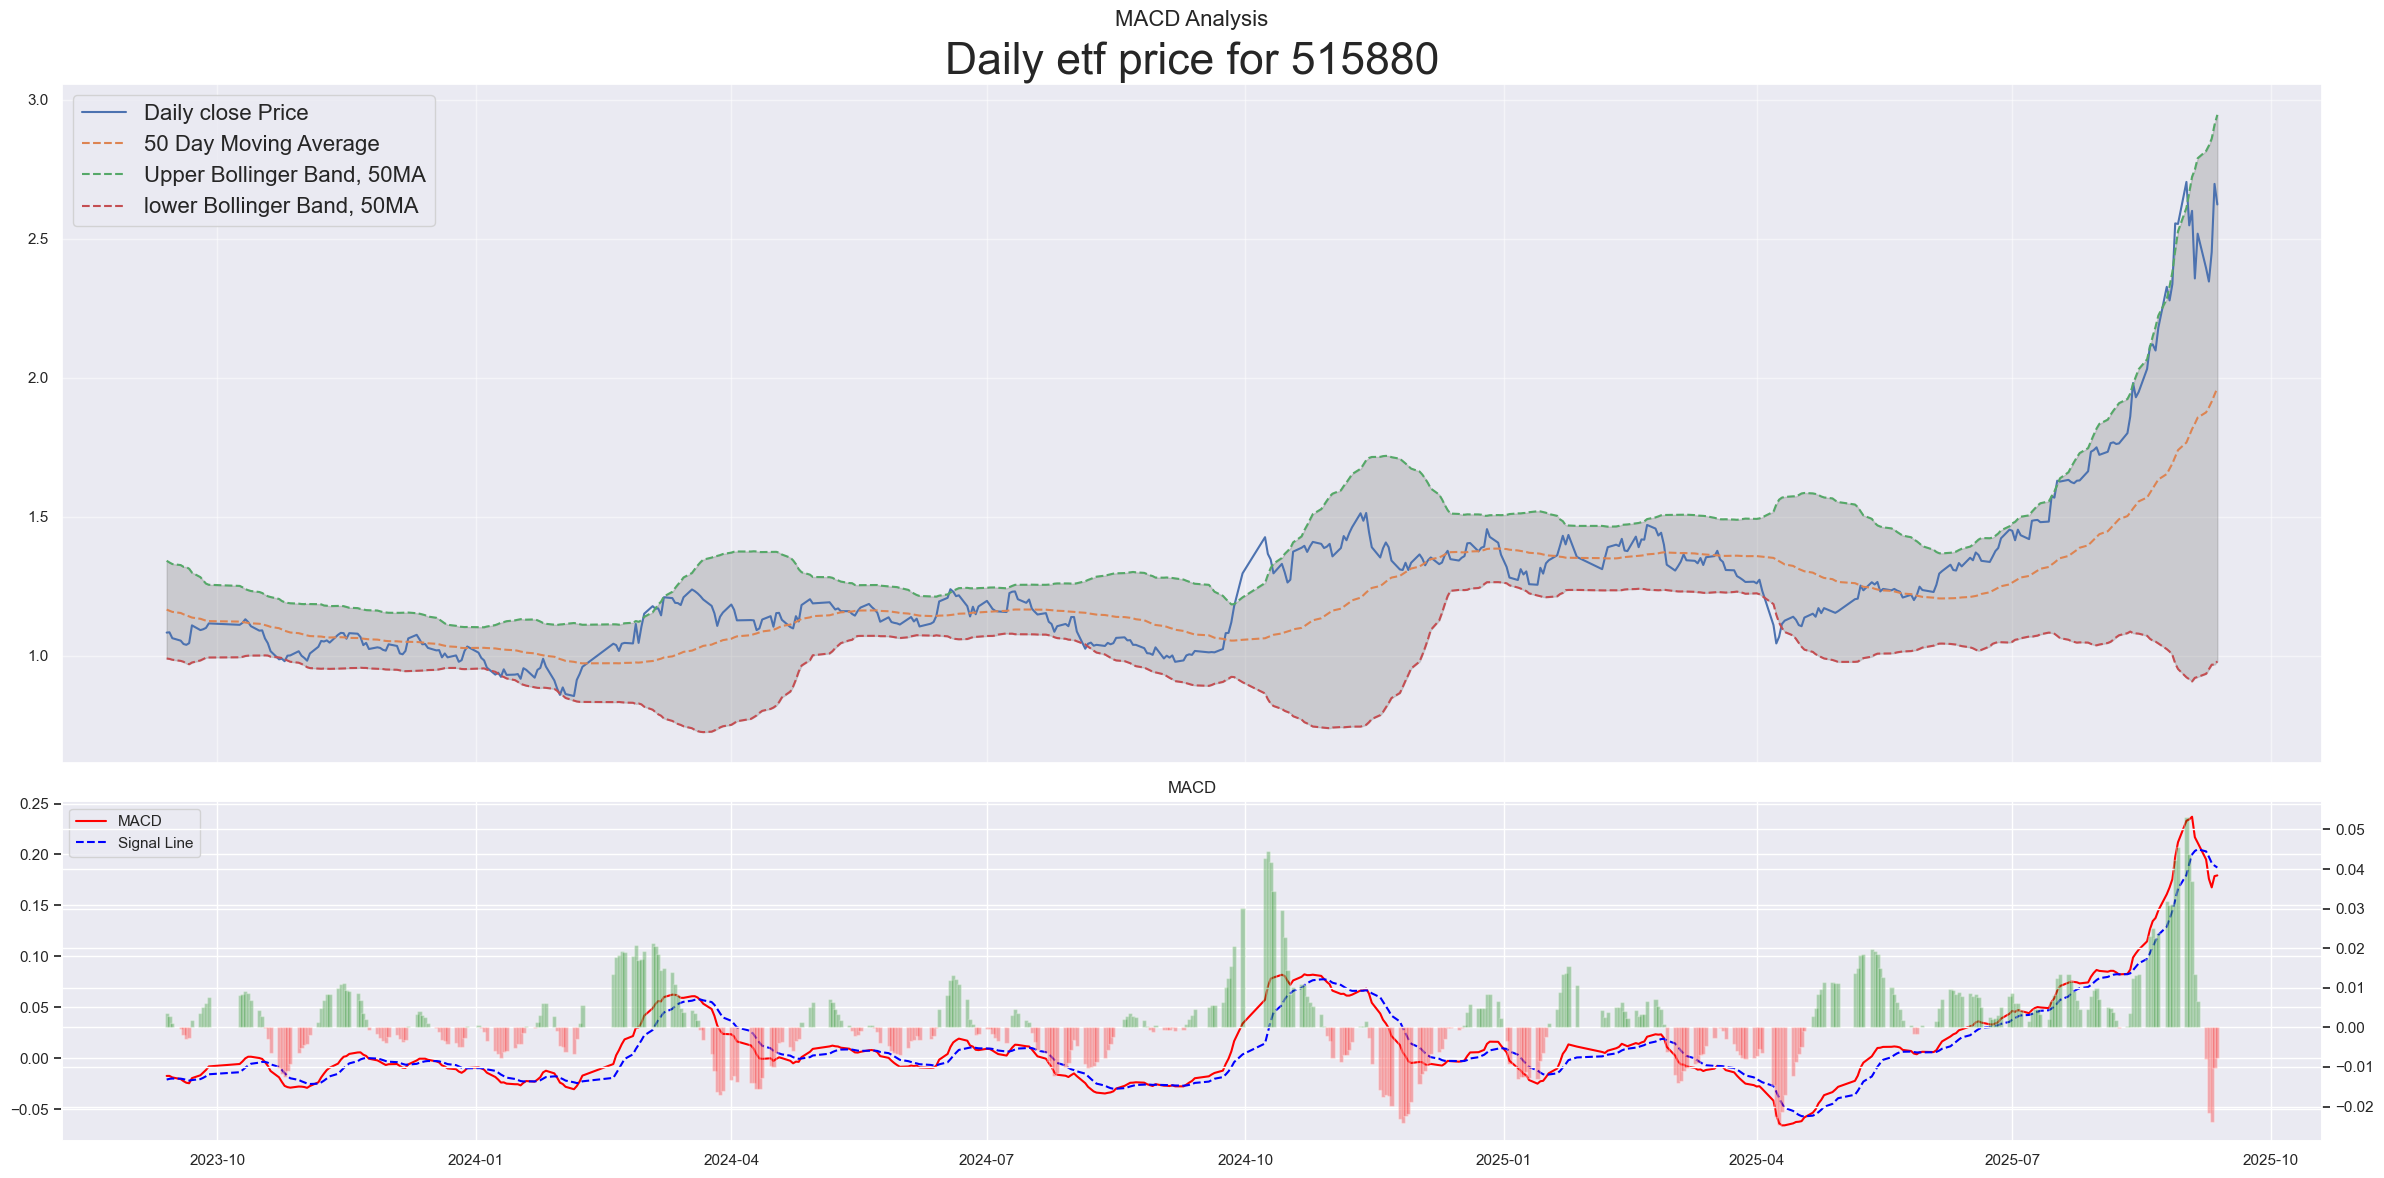

In [21]:
# 通信
etf_code = "515880"
etf_strategy(etf_code).output()

* Current etf price: 0.77
* Recent high: 0.81
* Current etf price is at 95.78% of recent high
Latest 20 Day MA: 0.75
Latest lower Bollinger Band, 20MA: 0.71
Latest higher Bollinger Band, 20MA: 0.8
Latest 50 Day MA: 0.71
Latest lower Bollinger Band, 50MA: 0.6
Latest higher Bollinger Band, 50MA: 0.83
Latest 50 Day EMA: 0.72
Latest 120 Day MA: 0.64
Latest 200 Day MA: 0.6
Latest 200 Day EMA: 0.63
Latest 10 Week MA: 0.72
Latest 20 Week MA: 0.66
Latest 30 Week MA: 0.63
Latest 40 Week MA: 0.61
Latest Lower Weekly Bollinger Band, 20MA: 0.52
Latest Higher Weekly Bollinger Band, 20MA: 0.8

Latest RSI: 57.28 
Latest MACD Divergence: -0.0008 
20MA break point: 0.76
20MA lower Bollinger Band break point: 0.7
20MA Upper Bollinger Band break point: 0.81
50MA break point: 0.72
50MA lower Bollinger Band break point: 0.6
50MA Upper Bollinger Band break point: 0.83
120MA break point: 0.64
200MA break point: 0.6


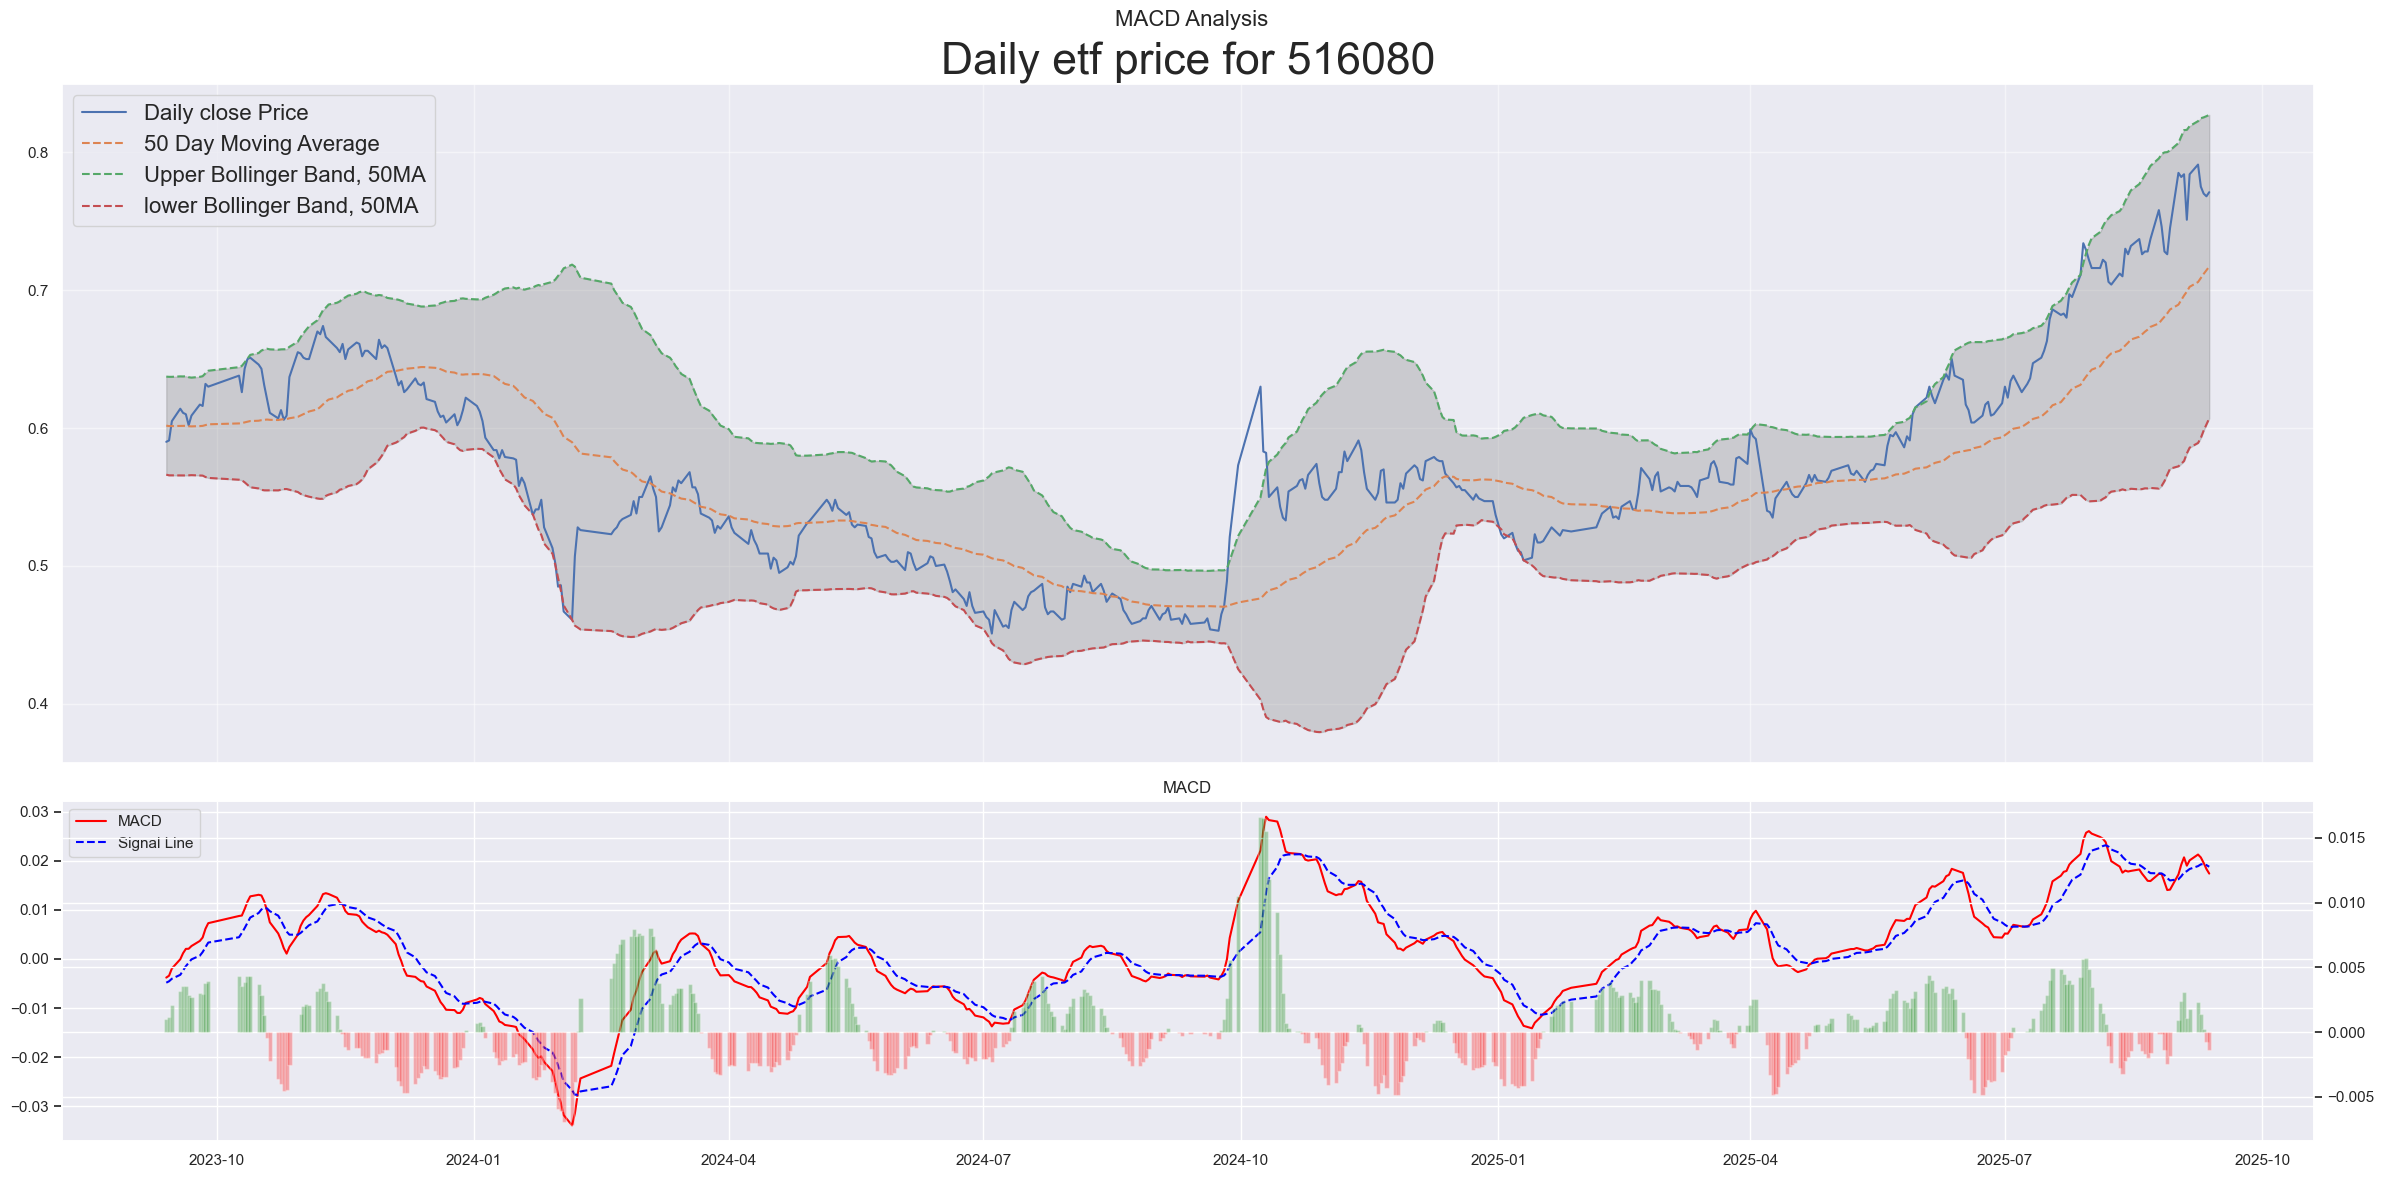

In [22]:
# 创新药
etf_code = "516080"
etf_strategy(etf_code).output()

* Current etf price: 1.03
* Recent high: 1.21
* Current etf price is at 85.48% of recent high
Latest 20 Day MA: 1.05
Latest lower Bollinger Band, 20MA: 1.01
Latest higher Bollinger Band, 20MA: 1.08
Latest 50 Day MA: 1.03
Latest lower Bollinger Band, 50MA: 0.96
Latest higher Bollinger Band, 50MA: 1.09
Latest 50 Day EMA: 1.03
Latest 120 Day MA: 0.99
Latest 200 Day MA: 0.99
Latest 200 Day EMA: 1.0
Latest 10 Week MA: 1.03
Latest 20 Week MA: 1.0
Latest 30 Week MA: 0.99
Latest 40 Week MA: 0.99
Latest Lower Weekly Bollinger Band, 20MA: 0.93
Latest Higher Weekly Bollinger Band, 20MA: 1.07

Latest RSI: 35.71 
Latest MACD Divergence: -0.0032 
20MA crosses 50MA at 0.48
20MA break point: 1.05
20MA lower Bollinger Band break point: 1.01
20MA Upper Bollinger Band break point: 1.09
50MA break point: 1.03
50MA lower Bollinger Band break point: 0.96
50MA Upper Bollinger Band break point: 1.1
120MA break point: 1.0
200MA break point: 0.99


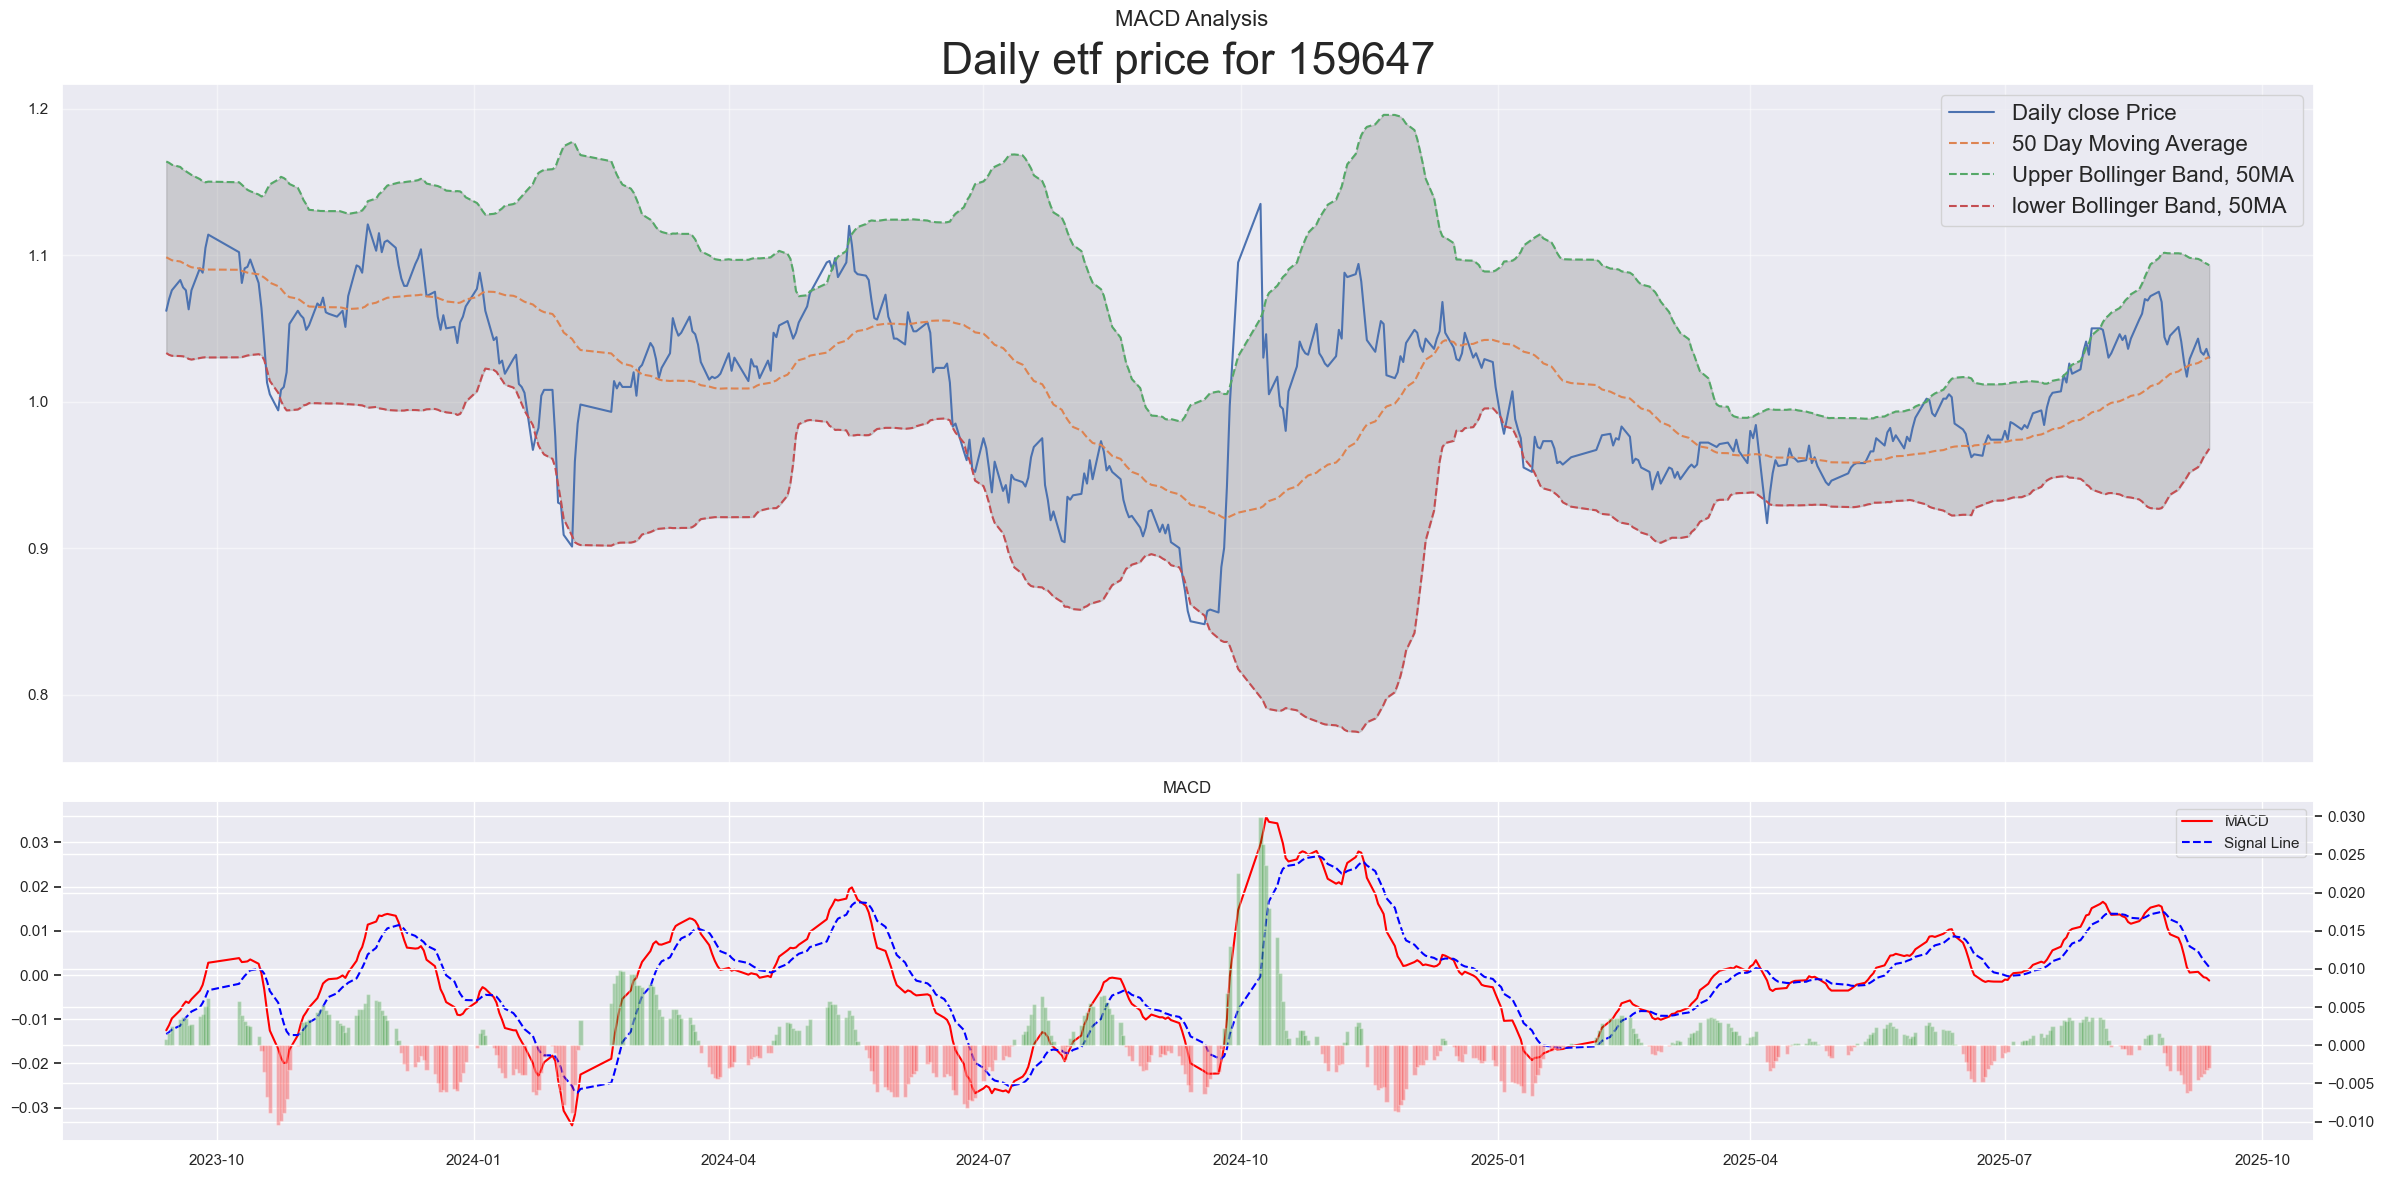

In [23]:
# 中药
etf_code = "159647"
etf_strategy(etf_code).output()

* Current etf price: 1.06
* Recent high: 1.4
* Current etf price is at 75.99000000000001% of recent high
Latest 20 Day MA: 1.07
Latest lower Bollinger Band, 20MA: 1.03
Latest higher Bollinger Band, 20MA: 1.11
Latest 50 Day MA: 1.07
Latest lower Bollinger Band, 50MA: 0.98
Latest higher Bollinger Band, 50MA: 1.16
Latest 50 Day EMA: 1.06
Latest 120 Day MA: 1.02
Latest 200 Day MA: 1.05
Latest 200 Day EMA: 1.05
Latest 10 Week MA: 1.07
Latest 20 Week MA: 1.03
Latest 30 Week MA: 1.02
Latest 40 Week MA: 1.04
Latest Lower Weekly Bollinger Band, 20MA: 0.93
Latest Higher Weekly Bollinger Band, 20MA: 1.12

Latest RSI: 35.38 
Latest MACD Divergence: -0.0029 
20MA crosses 50MA at 0.99
20MA break point: 1.07
20MA lower Bollinger Band break point: 1.02
20MA Upper Bollinger Band break point: 1.12
50MA break point: 1.07
50MA lower Bollinger Band break point: 0.97
50MA Upper Bollinger Band break point: 1.16
120MA break point: 1.02
200MA break point: 1.05


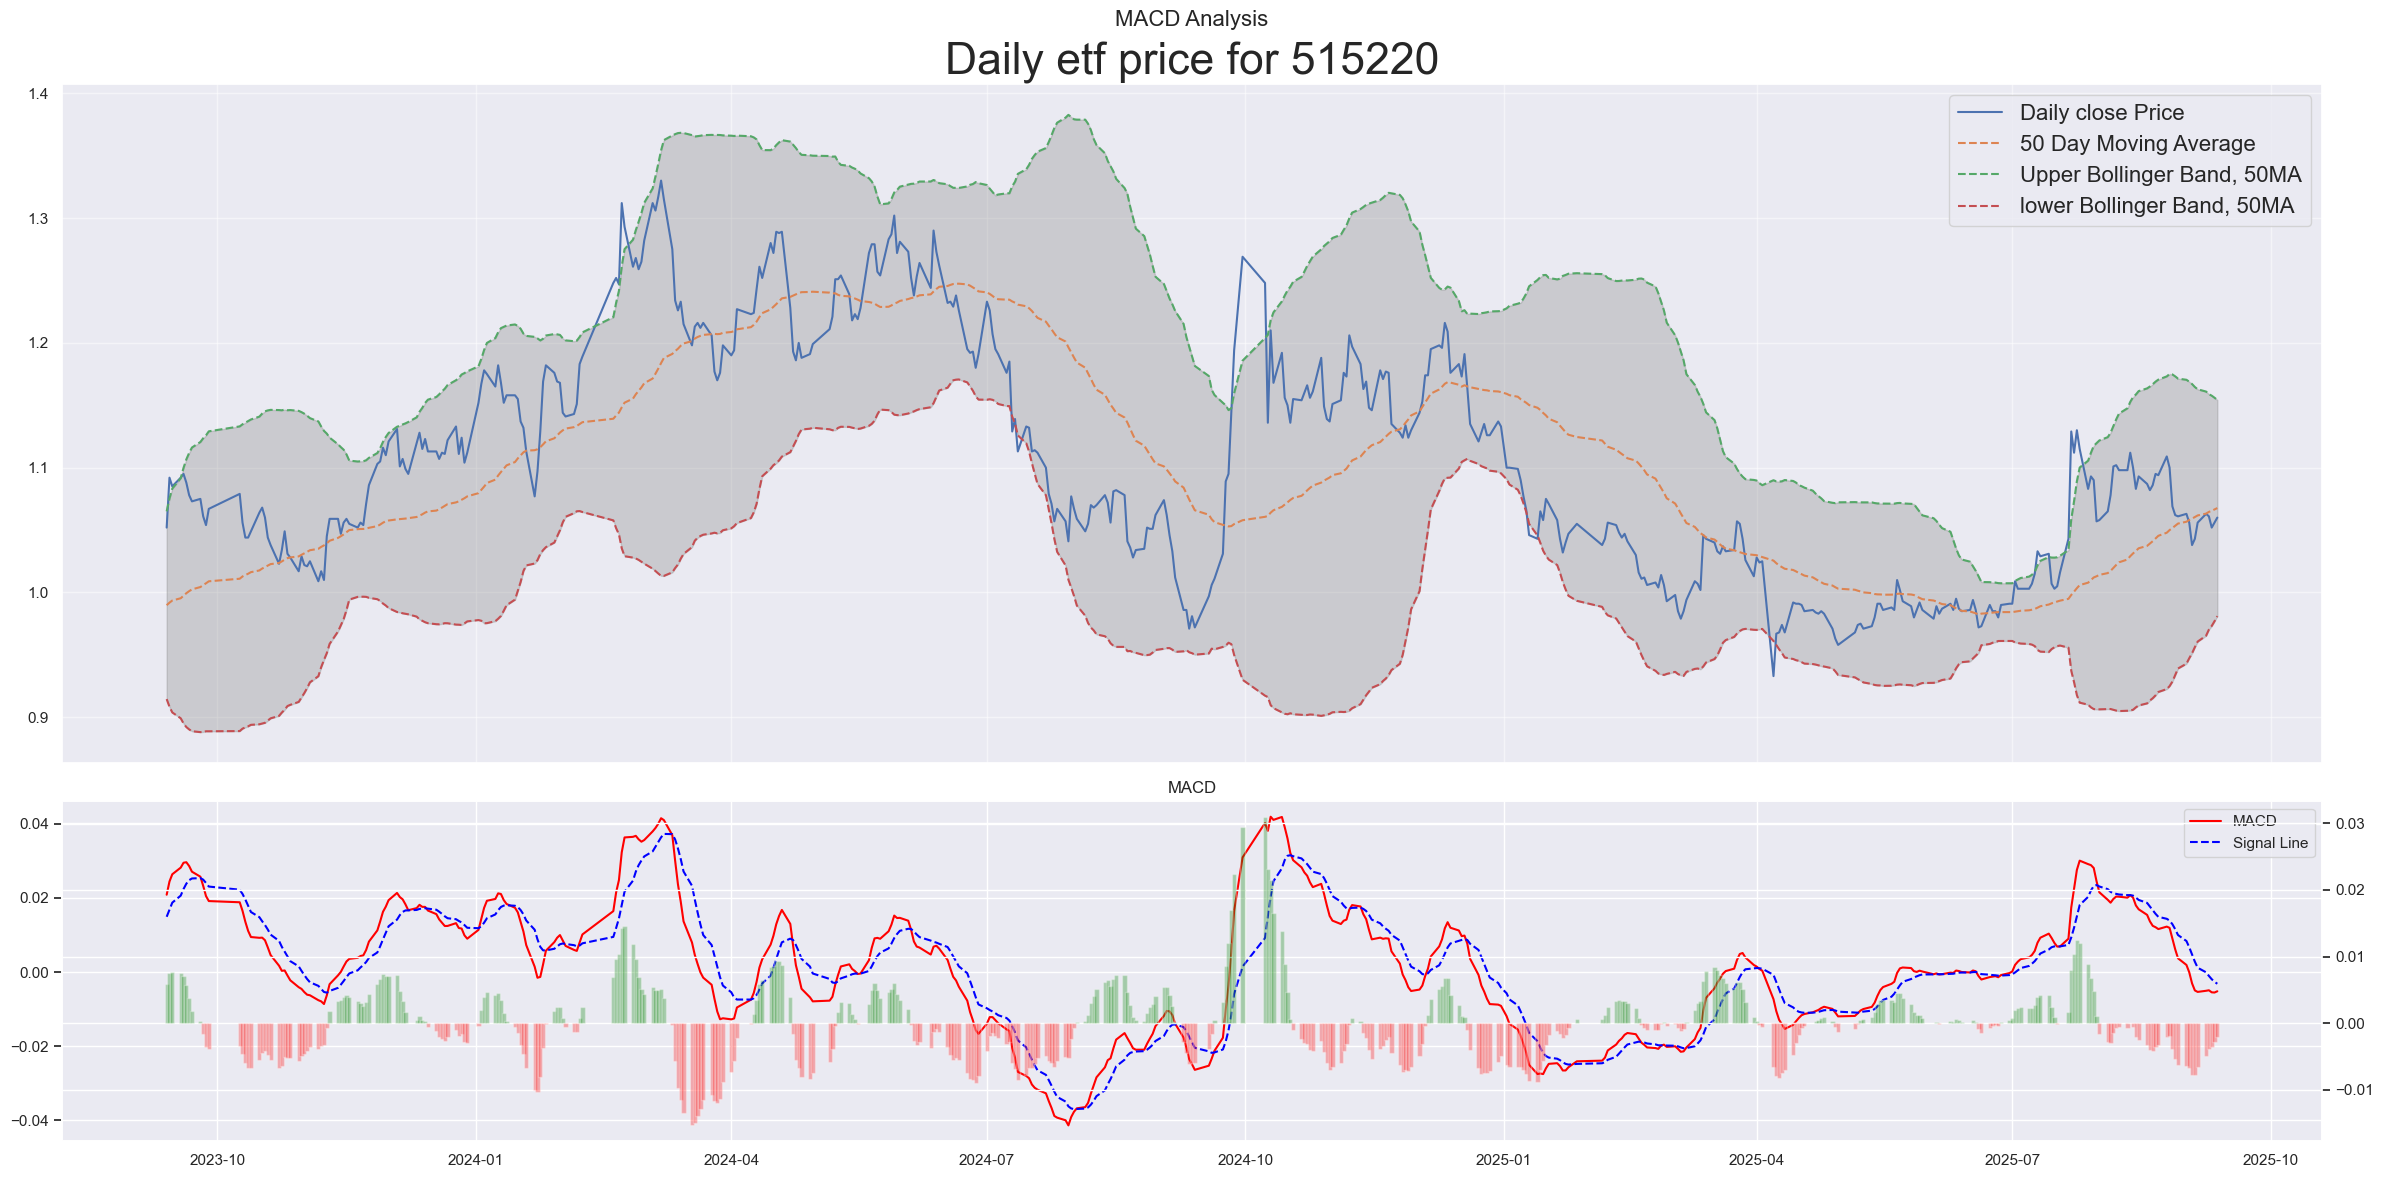

In [24]:
# 煤炭
etf_code = "515220"
etf_strategy(etf_code).output()

* Current etf price: 1.18
* Recent high: 1.24
* Current etf price is at 95.48% of recent high
Latest 20 Day MA: 1.2
Latest lower Bollinger Band, 20MA: 1.18
Latest higher Bollinger Band, 20MA: 1.22
Latest 50 Day MA: 1.2
Latest lower Bollinger Band, 50MA: 1.17
Latest higher Bollinger Band, 50MA: 1.23
Latest 50 Day EMA: 1.19
Latest 120 Day MA: 1.17
Latest 200 Day MA: 1.14
Latest 200 Day EMA: 1.14
Latest 10 Week MA: 1.2
Latest 20 Week MA: 1.18
Latest 30 Week MA: 1.15
Latest 40 Week MA: 1.14
Latest Lower Weekly Bollinger Band, 20MA: 1.12
Latest Higher Weekly Bollinger Band, 20MA: 1.24

Latest RSI: 39.51 
Latest MACD Divergence: -0.0011 
20MA crosses 50MA at 1.36
20MA break point: 1.2
20MA lower Bollinger Band break point: 1.17
20MA Upper Bollinger Band break point: 1.22
50MA break point: 1.2
50MA lower Bollinger Band break point: 1.17
50MA Upper Bollinger Band break point: 1.24
120MA break point: 1.17
200MA break point: 1.14


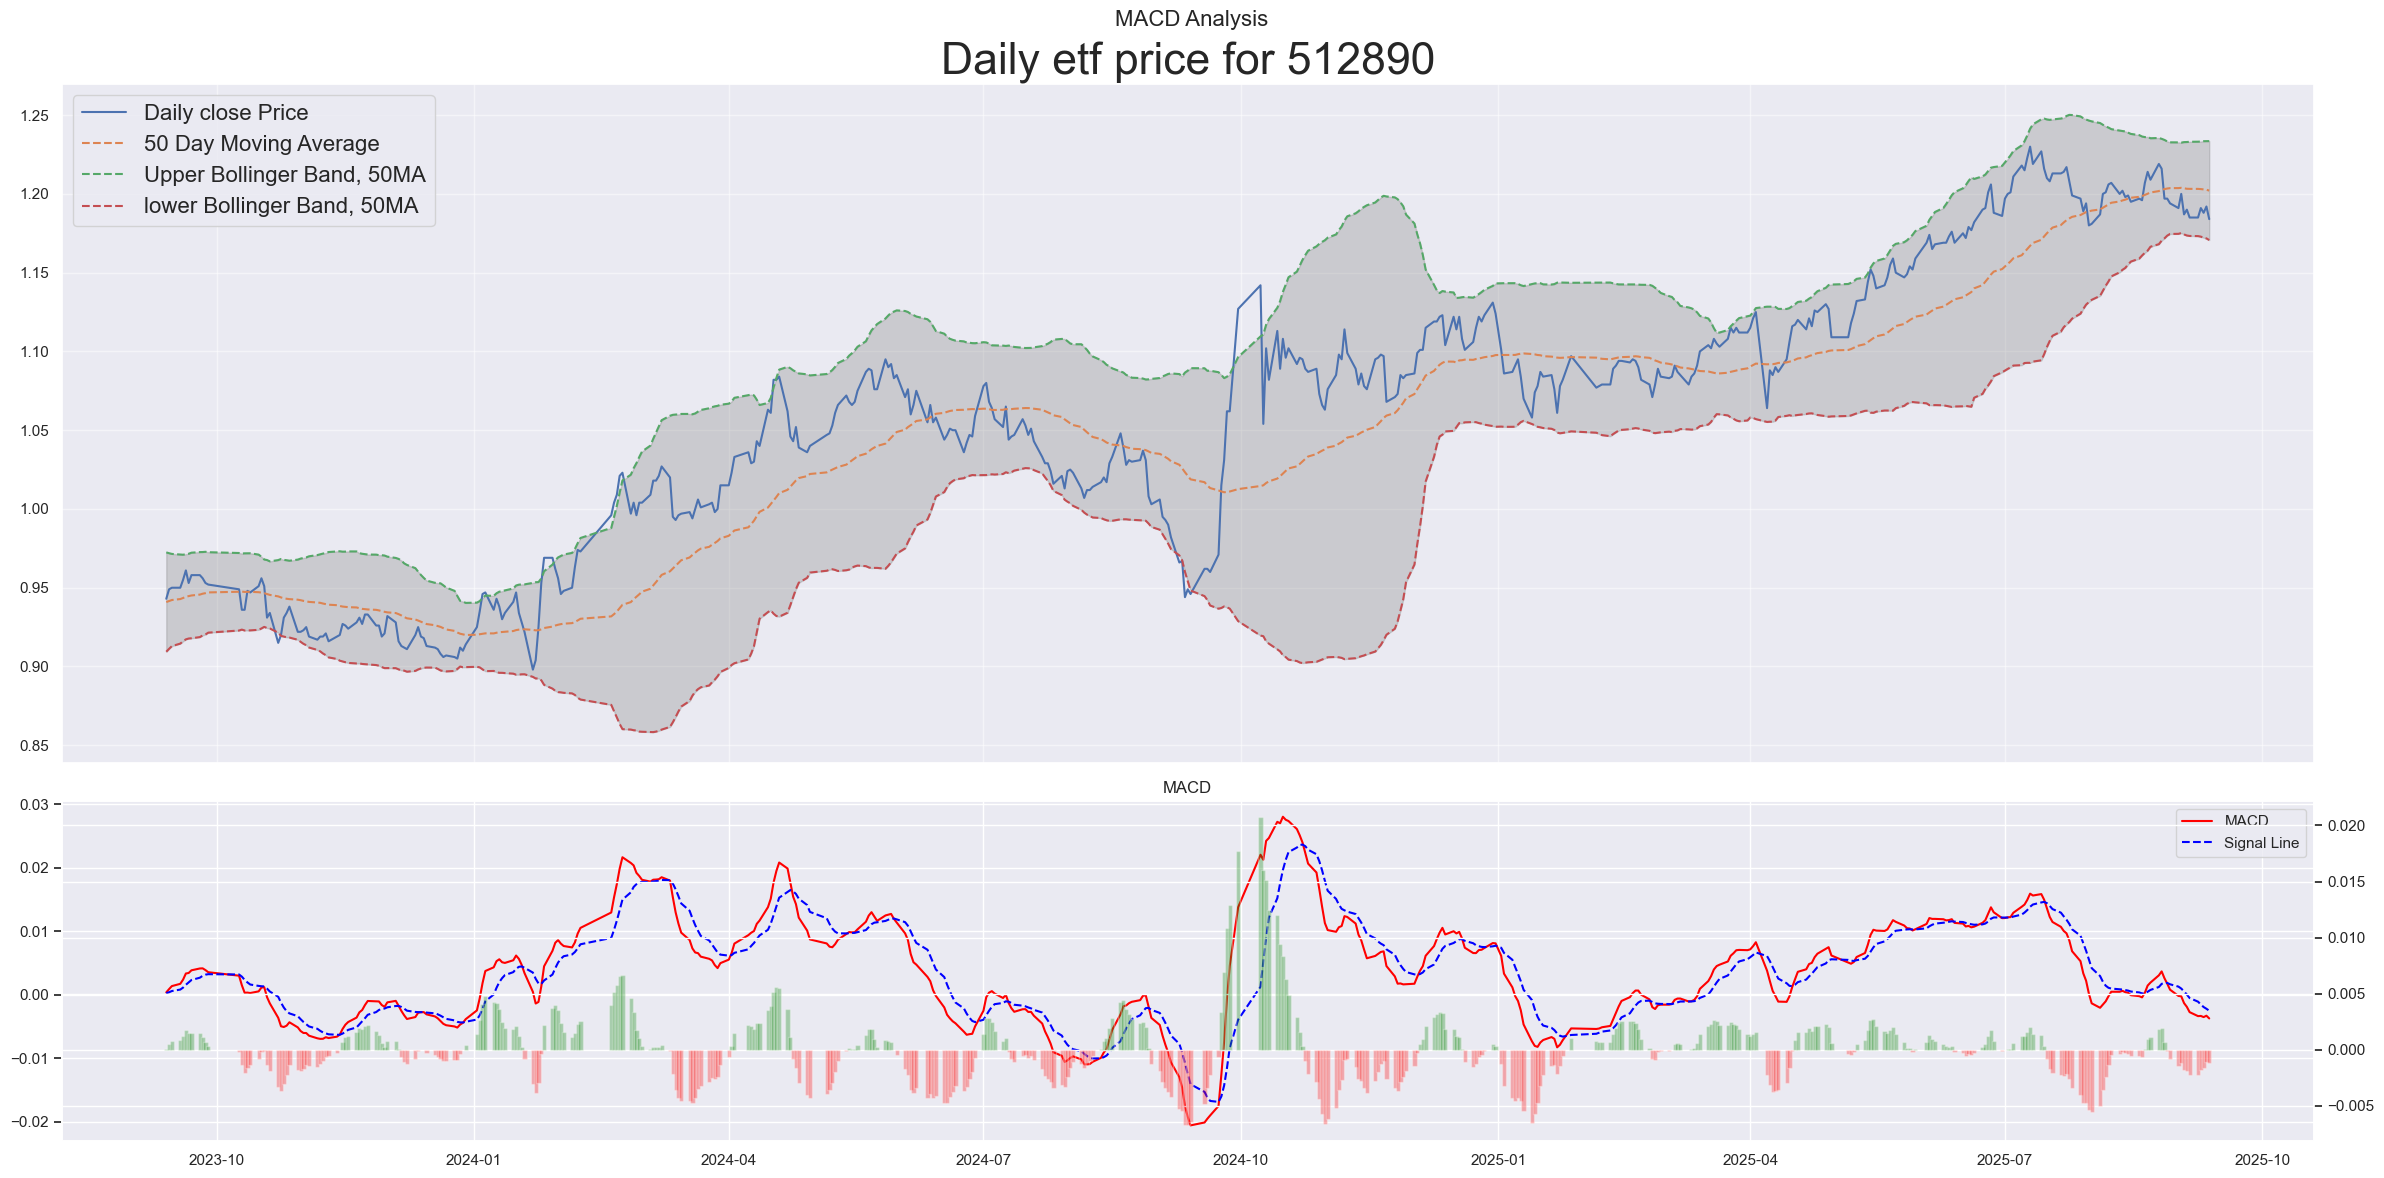

Regression price since launch: 1.2


In [25]:
# 红利低波
etf_code = "512890"
etf_strategy(etf_code).output()
print(f'Regression price since launch: {etf_regression(etf_code)}')

* Current etf price: 1.42
* Recent high: 1.56
* Current etf price is at 91.52% of recent high
Latest 20 Day MA: 1.43
Latest lower Bollinger Band, 20MA: 1.41
Latest higher Bollinger Band, 20MA: 1.45
Latest 50 Day MA: 1.43
Latest lower Bollinger Band, 50MA: 1.4
Latest higher Bollinger Band, 50MA: 1.46
Latest 50 Day EMA: 1.42
Latest 120 Day MA: 1.38
Latest 200 Day MA: 1.37
Latest 200 Day EMA: 1.37
Latest 10 Week MA: 1.43
Latest 20 Week MA: 1.4
Latest 30 Week MA: 1.37
Latest 40 Week MA: 1.37
Latest Lower Weekly Bollinger Band, 20MA: 1.32
Latest Higher Weekly Bollinger Band, 20MA: 1.47

Latest RSI: 44.32 
Latest MACD Divergence: -0.0005 
20MA crosses 50MA at 1.42
20MA break point: 1.43
20MA lower Bollinger Band break point: 1.41
20MA Upper Bollinger Band break point: 1.46
50MA break point: 1.43
50MA lower Bollinger Band break point: 1.39
50MA Upper Bollinger Band break point: 1.47
120MA break point: 1.39
200MA break point: 1.37


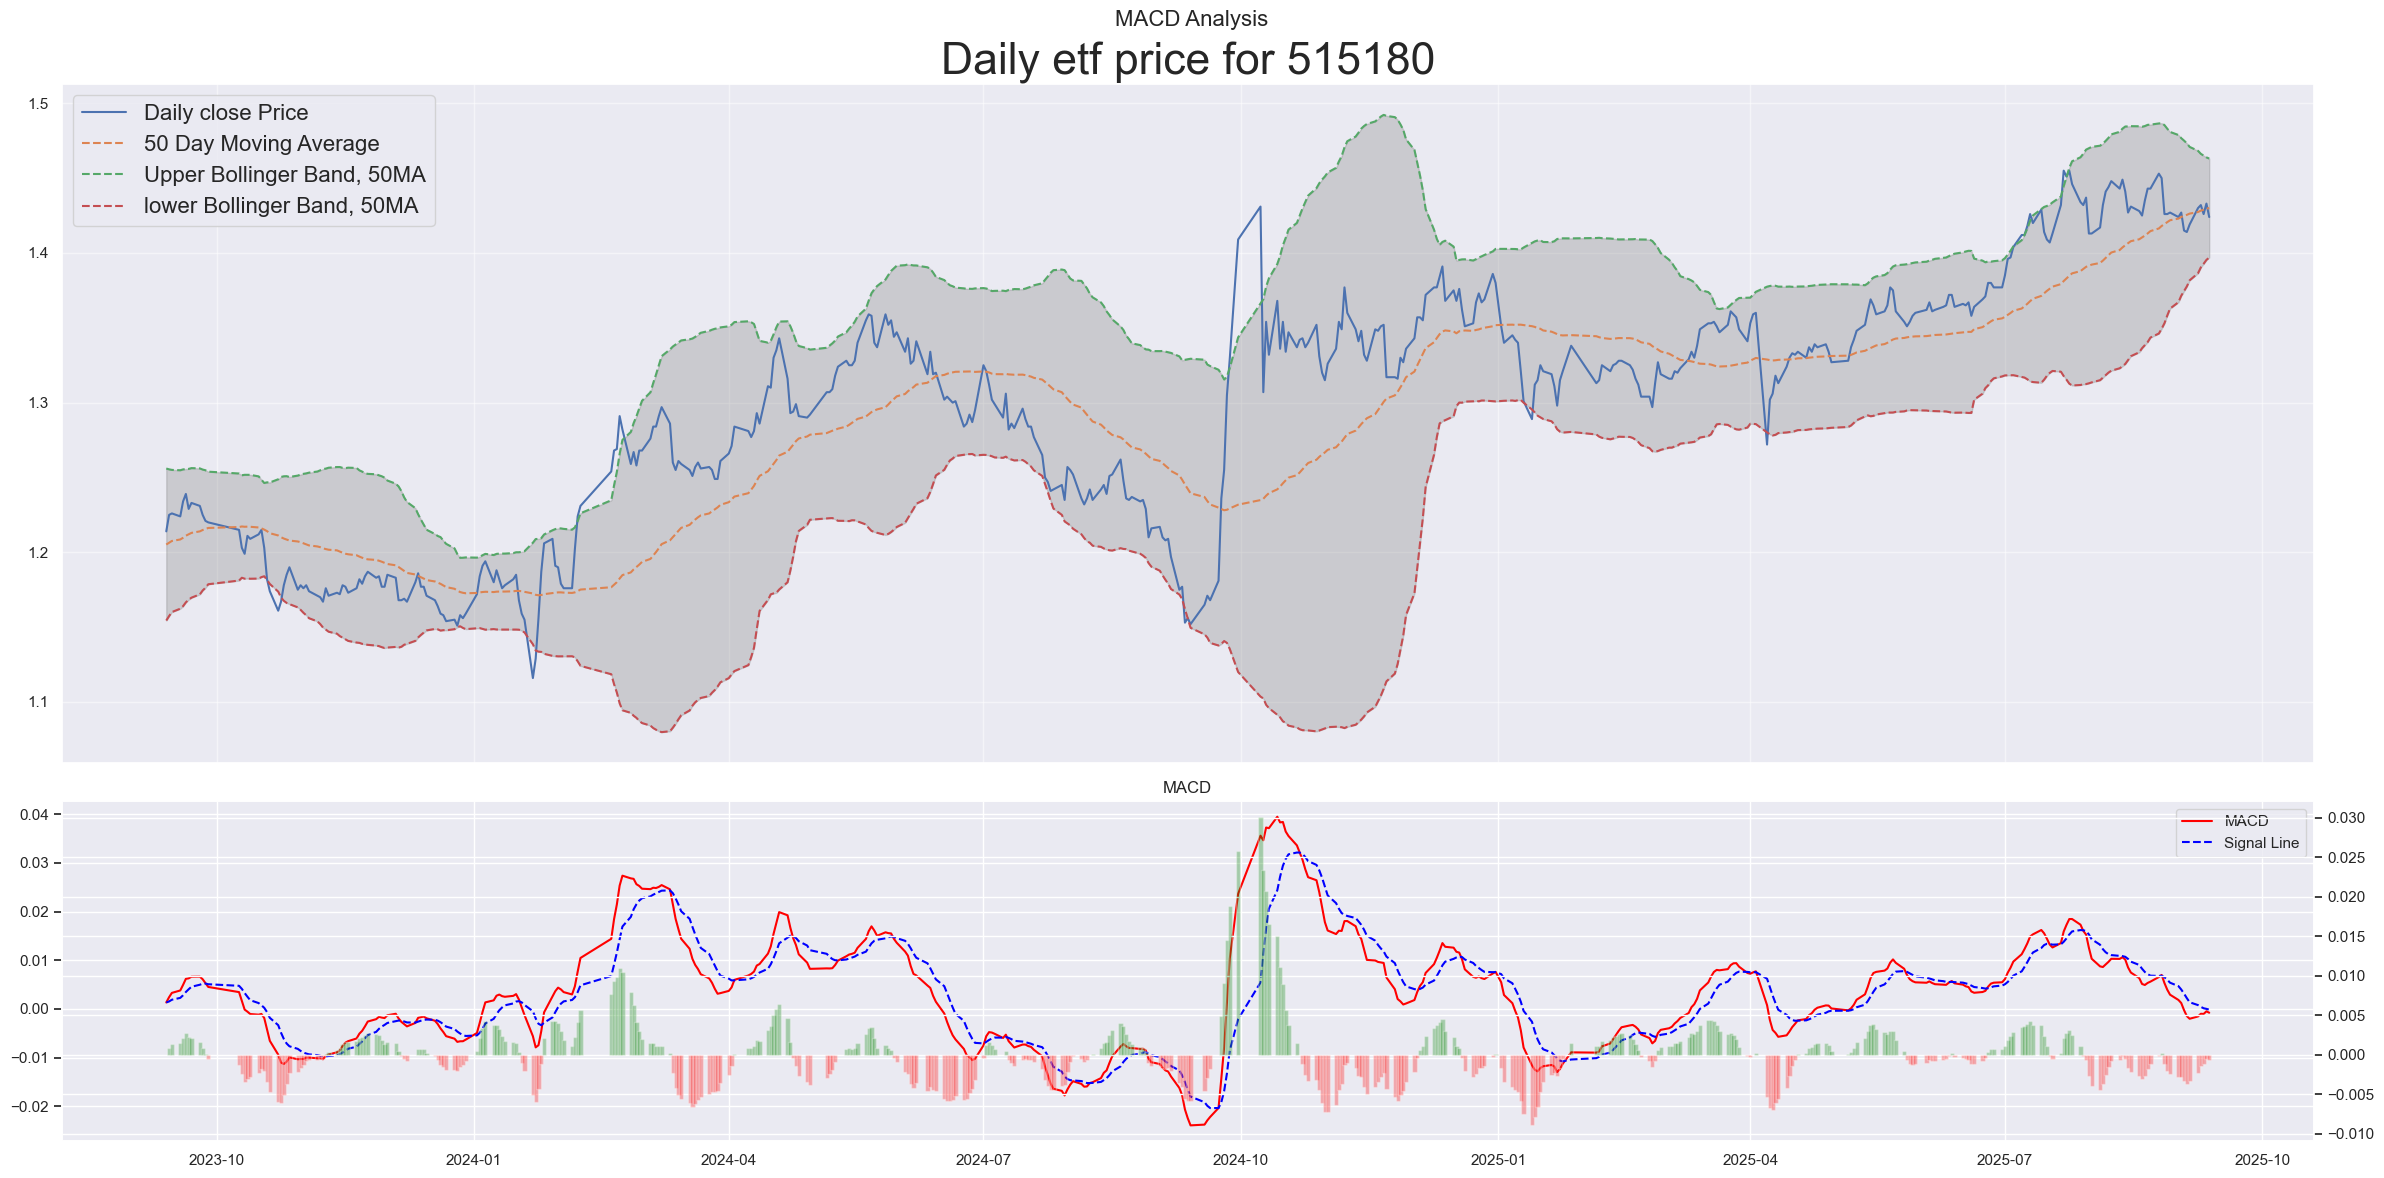

Regression price since launch: 1.45


In [26]:
# 红利
etf_code = "515180"
etf_strategy(etf_code).output()
print(f'Regression price since launch: {etf_regression(etf_code)}')

* Current commodity price: 147    831.0
Name: 现价, dtype: float64
* Recent high: 836.0
* Current commodity price is at 147    99.4
Name: 现价, dtype: float64% of recent high
Latest 20 Day MA: 793.08
Latest lower Bollinger Band, 20MA: 748.83
Latest higher Bollinger Band, 20MA: 837.32
Latest 50 Day MA: 781.69
Latest lower Bollinger Band, 50MA: 738.71
Latest higher Bollinger Band, 50MA: 824.67
Latest 50 Day EMA: 786.23
Latest 120 Day MA: 771.81
Latest 200 Day MA: 721.97
Latest 200 Day EMA: 726.49

Latest RSI: 91.65 
Latest MACD Divergence: 4.6 
20MA crosses 50MA at 395.11
20MA break point: 794.1
20MA lower Bollinger Band break point: 742.47
20MA Upper Bollinger Band break point: 845.74
50MA break point: 781.89
50MA lower Bollinger Band break point: 735.03
50MA Upper Bollinger Band break point: 828.75
120MA break point: 772.36
200MA break point: 722.54


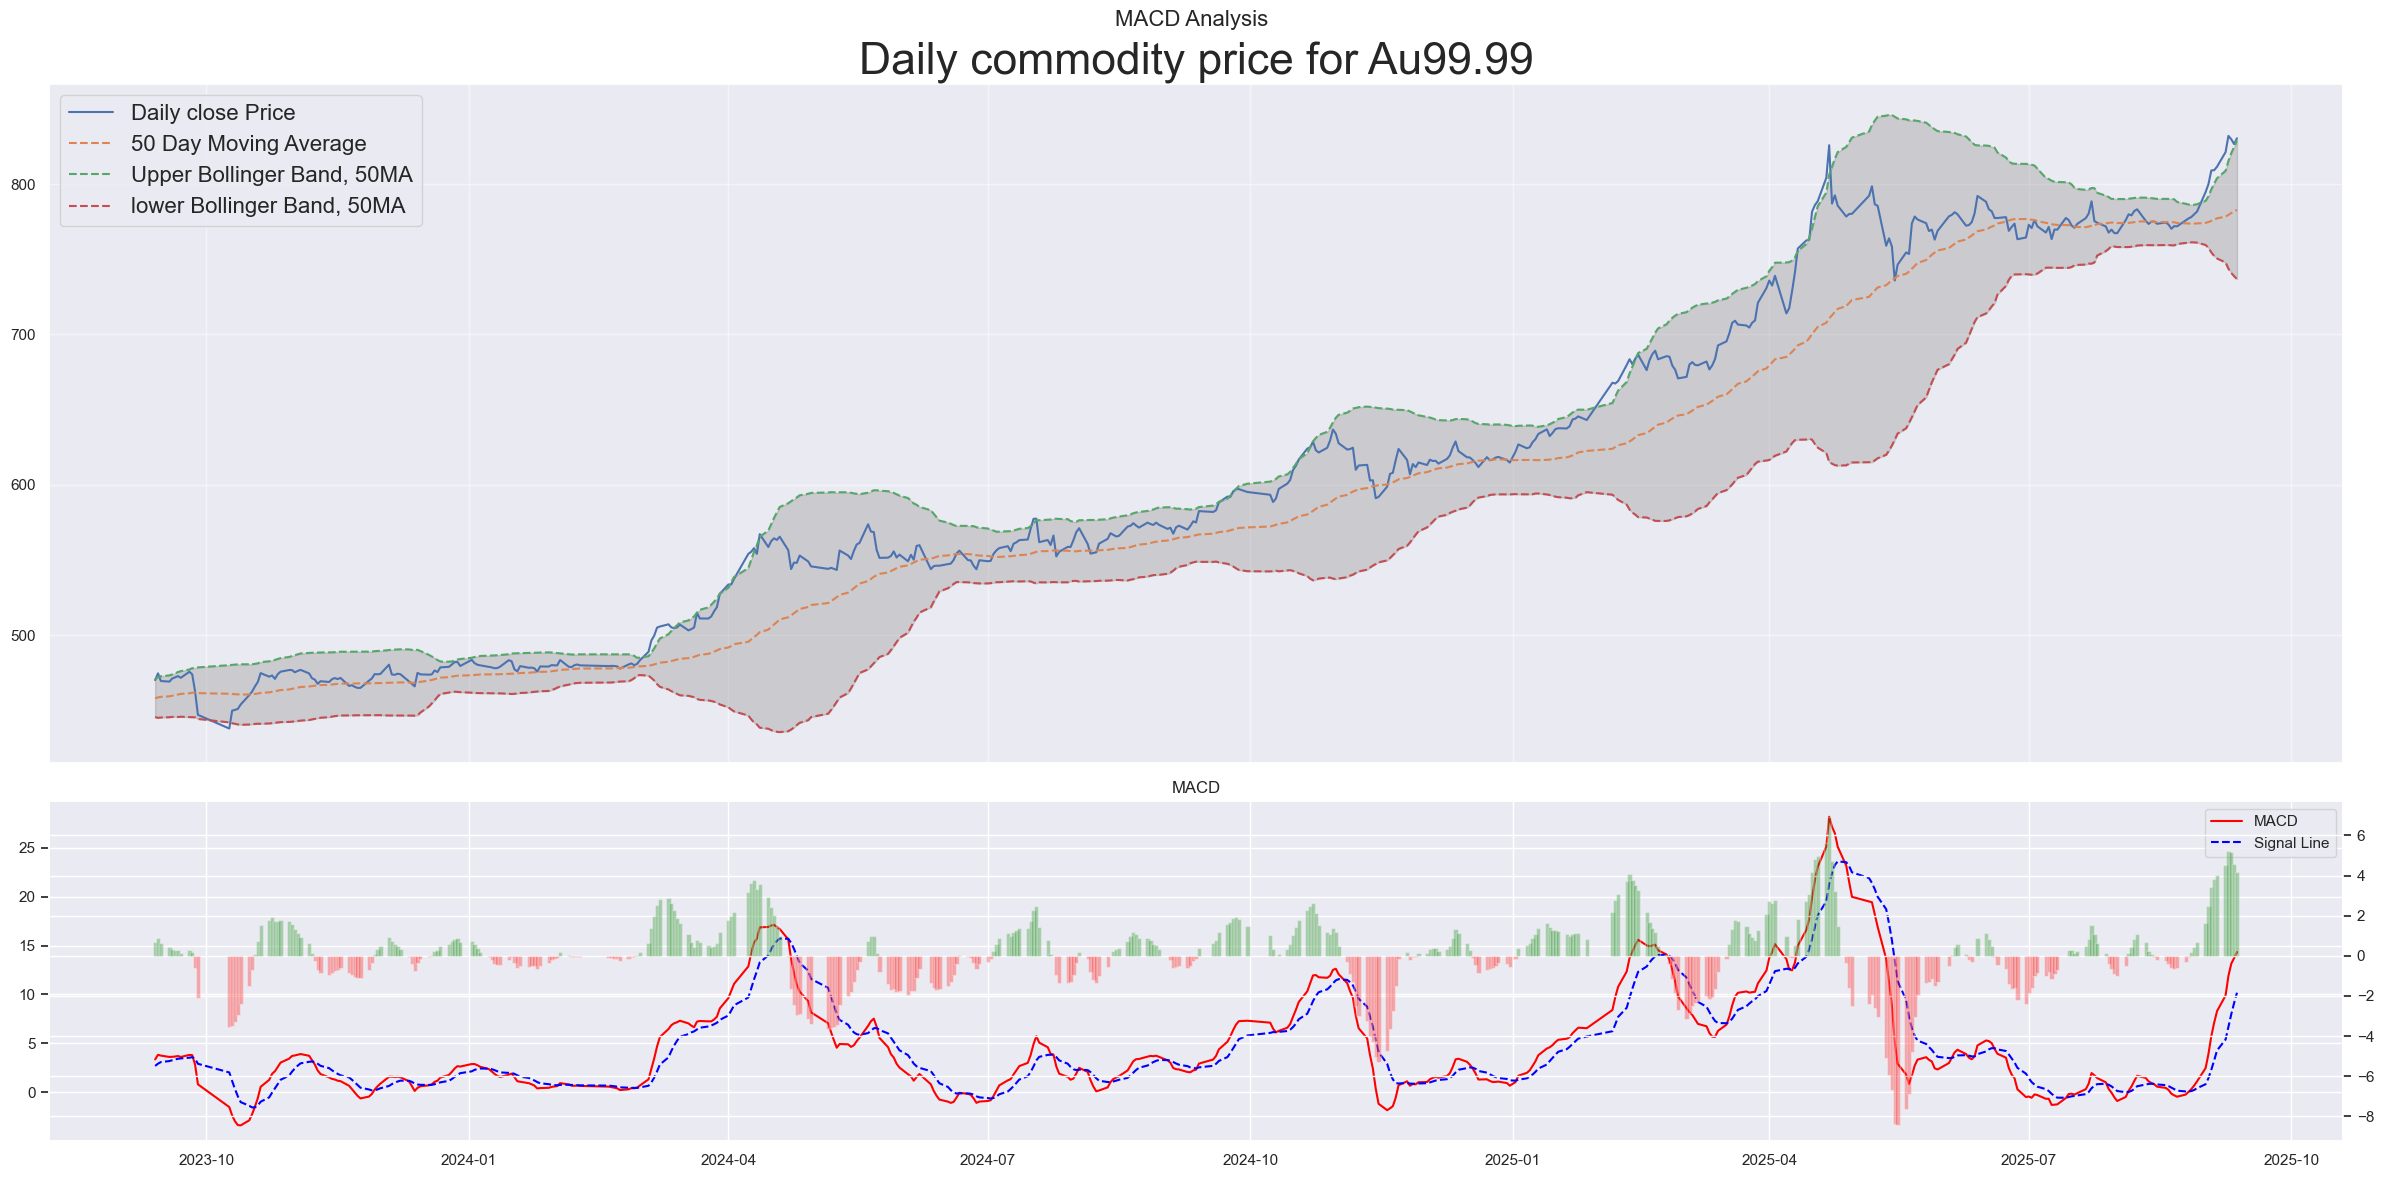

In [27]:
# 黄金
commodity_code = 'Au99.99'
commodity_strategy(commodity_code).output()

* Current etf price: 1.03
* Recent high: 1.04
* Current etf price is at 98.65% of recent high
Latest 20 Day MA: 0.98
Latest lower Bollinger Band, 20MA: 0.92
Latest higher Bollinger Band, 20MA: 1.05
Latest 50 Day MA: 0.92
Latest lower Bollinger Band, 50MA: 0.78
Latest higher Bollinger Band, 50MA: 1.06
Latest 50 Day EMA: 0.93
Latest 120 Day MA: 0.86
Latest 200 Day MA: 0.84
Latest 200 Day EMA: 0.84
Latest 10 Week MA: 0.93
Latest 20 Week MA: 0.87
Latest 30 Week MA: 0.86
Latest 40 Week MA: 0.84
Latest Lower Weekly Bollinger Band, 20MA: 0.72
Latest Higher Weekly Bollinger Band, 20MA: 1.02

Latest RSI: 62.29 
Latest MACD Divergence: 0.001 
20MA break point: 0.99
20MA lower Bollinger Band break point: 0.92
20MA Upper Bollinger Band break point: 1.05
50MA break point: 0.92
50MA lower Bollinger Band break point: 0.77
50MA Upper Bollinger Band break point: 1.07
120MA break point: 0.86
200MA break point: 0.84


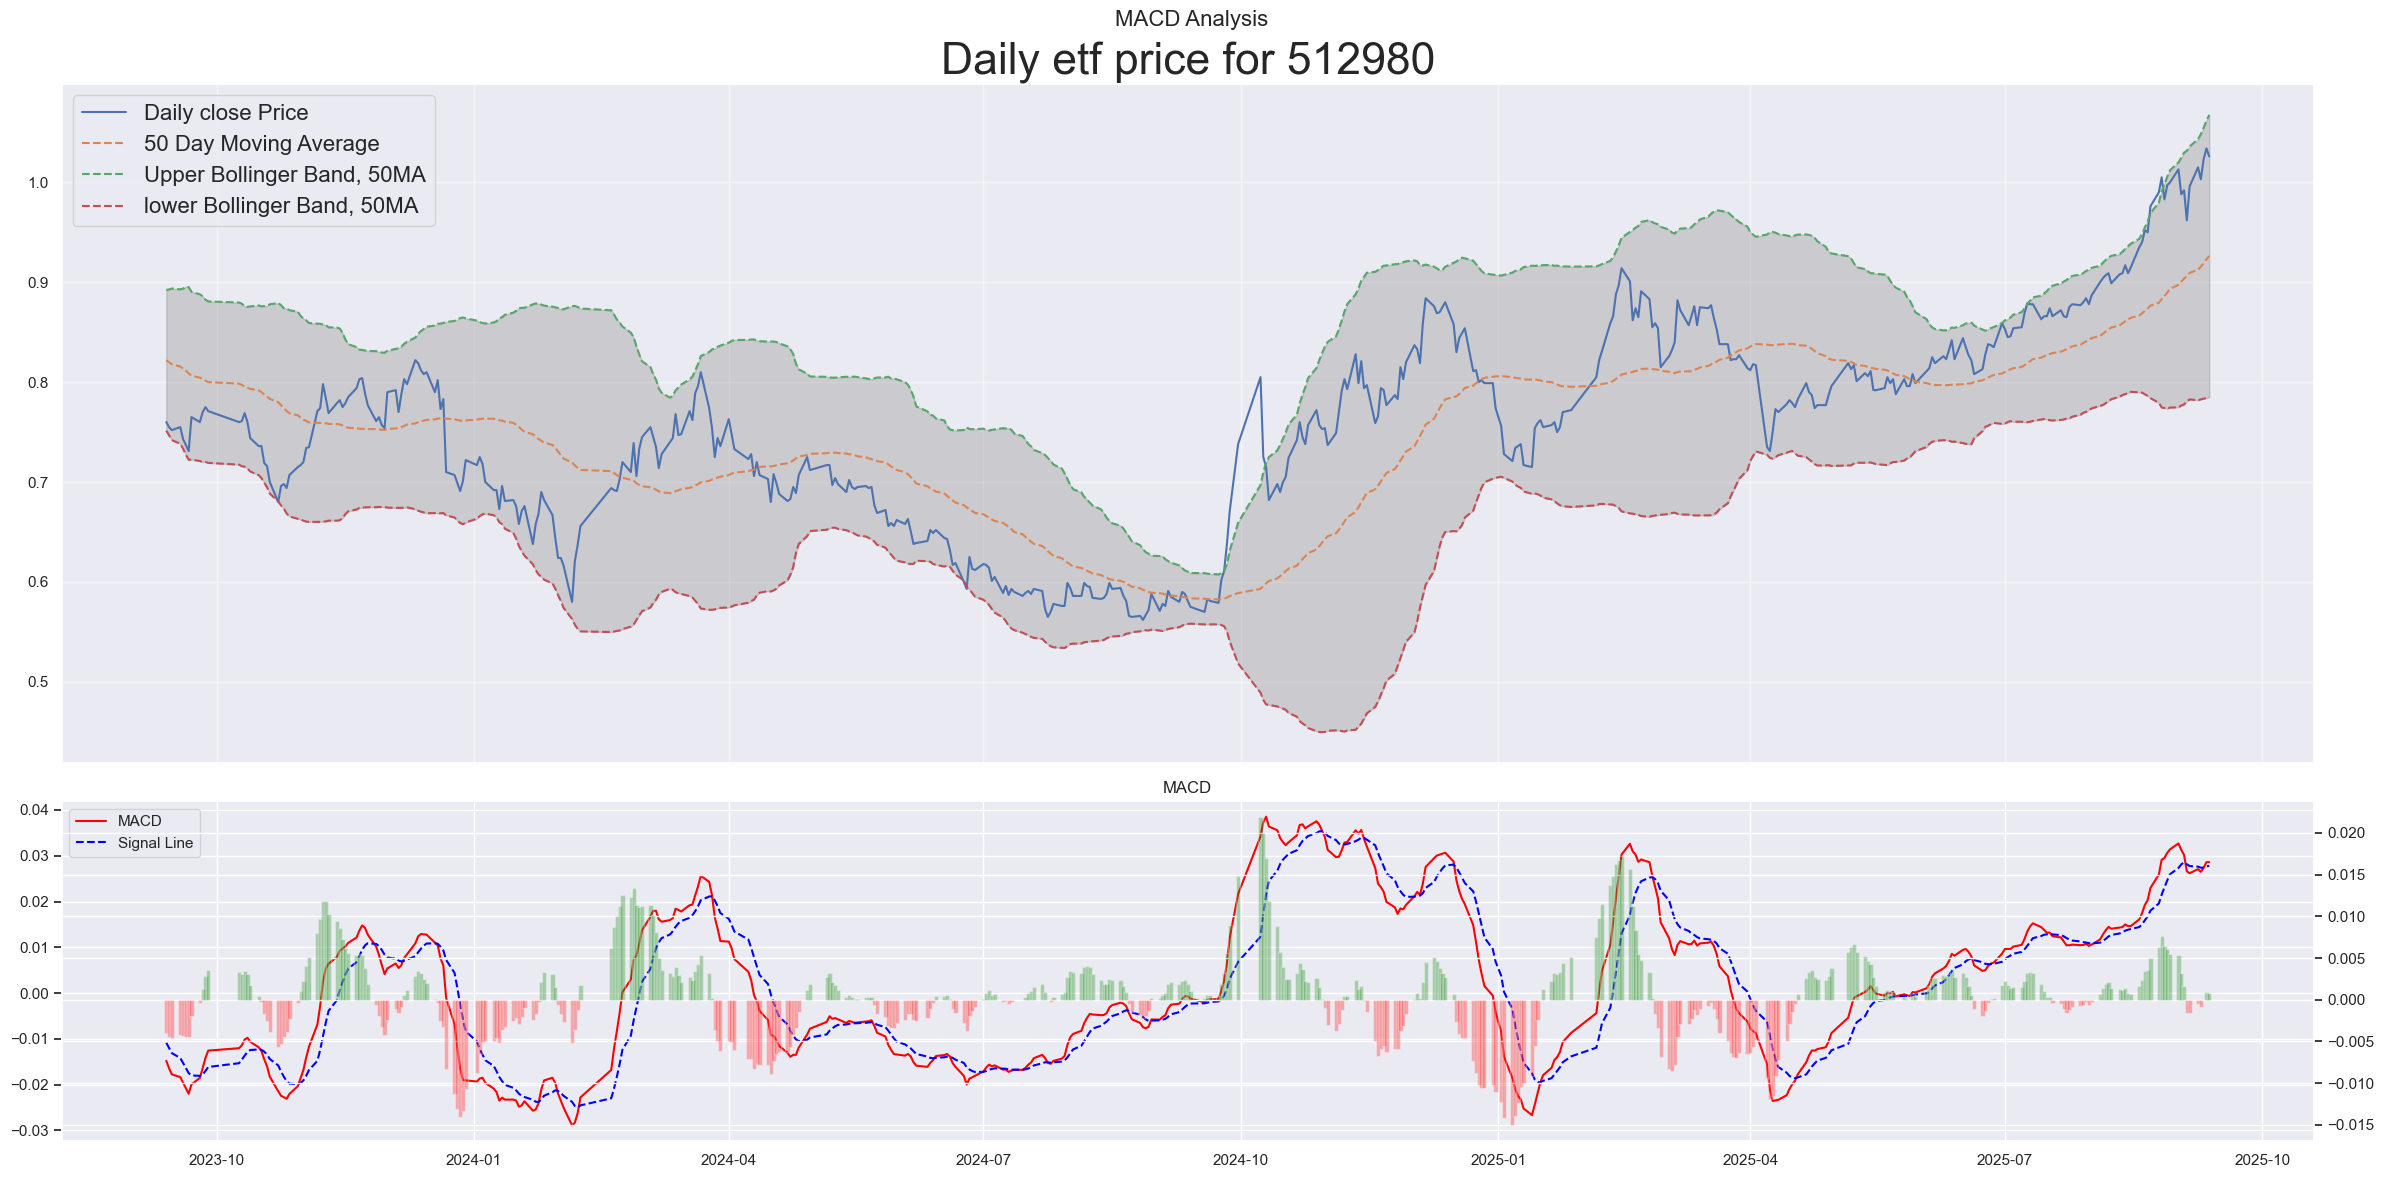

In [28]:
# 传媒
etf_code = "512980"
etf_strategy(etf_code).output()

In [29]:
# 地产
etf_code = "159940"
etf_strategy(etf_code).output()

ConnectTimeout: HTTPSConnectionPool(host='push2his.eastmoney.com', port=443): Max retries exceeded with url: /api/qt/stock/kline/get?fields1=f1%2Cf2%2Cf3%2Cf4%2Cf5%2Cf6&fields2=f51%2Cf52%2Cf53%2Cf54%2Cf55%2Cf56%2Cf57%2Cf58%2Cf59%2Cf60%2Cf61%2Cf116&ut=7eea3edcaed734bea9cbfc24409ed989&klt=101&fqt=1&beg=20220912&end=20250912&secid=0.159940 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x16c23ef60>, 'Connection to push2his.eastmoney.com timed out. (connect timeout=15)'))

In [ ]:
# 汽车
etf_code = "516110"
etf_strategy(etf_code).output()

In [ ]:
# 恒生科技
etf_code = "513260"
etf_strategy(etf_code).output()

In [ ]:
# 恒生医疗
etf_code = "513060"
etf_strategy(etf_code).output()

In [ ]:
# 恒生
etf_code = "513660"
etf_strategy(etf_code).output()

In [ ]:
# 恒生红利低波
etf_code = "159545"
etf_strategy(etf_code).output()

In [ ]:
# 上证50
etf_code = "510050"
etf_strategy(etf_code).output()

In [ ]:
# 沪港深500
etf_code = "517000"
etf_strategy(etf_code).output()

### Test a "momentum driven" strategy

In [ ]:
def backtest_momentum_strategy(price_df, initial_cash=100_000, cycle=21, window=20, sell_early=False):
    """
    Backtest the momentum strategy with X-trading-day evaluation cycle.
    Returns:
        result_df: Daily portfolio value DataFrame
        actions_df: Log of only buy/sell actions
    """
    price_df = price_df.sort_index()
    
    # cycle-day moving average
    ma = price_df.rolling(window=window).mean()
    
    # cycle-day % change
    pct_change = price_df.pct_change(cycle)
    
    # Portfolio state
    cash = initial_cash
    shares = 0
    current_stock = None
    portfolio_values = []
    actions = []

    dates = price_df.index
    
    # for i in range(cycle, len(dates)):  # start from the 22nd trading day
    for i in range(cycle, 21*13):  # Check performance for one year
        date = dates[i]
        
        # Step (1): every cycle trading days, rebalance
        if (i - cycle) % cycle == 0:
            # Sell previous stock if any
            if current_stock is not None:
                sell_price = price_df.loc[date, current_stock]
                cash += shares * sell_price
                actions.append([date, "SELL", current_stock, sell_price, shares])
                shares = 0
                current_stock = None
            
            # Find candidates above ma
            candidates = [s for s in price_df.columns 
                          if price_df.loc[date, s] > ma.loc[date, s]]
            
            if candidates:
                # Pick stock with largest cycle-day % change
                stock_changes = pct_change.loc[date, candidates]
                pick = stock_changes.idxmax()
                buy_price = price_df.loc[date, pick]
                current_stock = pick
                shares = cash // buy_price
                cash -= shares * buy_price
                actions.append([date, "BUY", pick, buy_price, shares])
        
        # Step (2): sell early if price drops below ma
        if sell_early and current_stock is not None:
            if price_df.loc[date, current_stock] < ma.loc[date, current_stock]:
                sell_price = price_df.loc[date, current_stock]
                cash += shares * sell_price
                actions.append([date, "SELL_EARLY", current_stock, sell_price, shares])
                shares = 0
                current_stock = None
        
        # Record portfolio value
        if current_stock is not None:
            value = cash + shares * price_df.loc[date, current_stock]
        else:
            value = cash
        portfolio_values.append((date, value))
    
    # Create results DataFrames
    result_df = pd.DataFrame(portfolio_values, columns=["Date", "PortfolioValue"])
    result_df.set_index("Date", inplace=True)
    
    actions_df = pd.DataFrame(actions, columns=["Date", "Action", "Stock", "Price", "Shares"])
    actions_df.set_index("Date", inplace=True)
    
    total_days = len(result_df)
    final_value = result_df["PortfolioValue"].iloc[-1]
    annualized_return = (final_value / initial_cash) ** (252 / total_days) - 1
    
    return result_df, actions_df, annualized_return


def average_annualized_return(price_df, initial_cash=100_000, n_test=100, cycle=21, window=20, sell_early=False):
    """
    Runs the strategy from different starting offsets (0-20) and averages annualized return.
    """
    returns = []
    for offset in range(n_test):  # 100 possible start offsets
        sliced_df = price_df.iloc[offset:].copy()
        if len(sliced_df) < 42:  # ensure enough data for lookback + holding
            continue
        _, _, ann_return = backtest_momentum_strategy(sliced_df, initial_cash, cycle=cycle, window=window, sell_early=sell_early)
        returns.append(ann_return)
    print(f"Average return: {np.mean(returns) if returns else np.nan}")
    print(f"Return STD: {np.std(returns) if returns else np.nan}")

    return returns

In [ ]:
etf_list = [
"516570",
"512820",
"512260",
"512480",
"512580",
"159948",
"562500",
"159819",
"512600",
"560880",
"512400",
# "159697", # history too short
"515880",
"516080",
"159647",
"515220",
"512890",
"512980",
"159940",
"516110",
"513260",
"513060",
"513660",
# "159545", # history too short
"510050",
]
etf_code = etf_list[0]

df_all = ak.fund_etf_hist_em(
            symbol=etf_code.upper(),
            start_date=(datetime.today() - relativedelta(years=5)).strftime('%Y%m%d'),
            end_date=datetime.today().strftime('%Y%m%d'),
            period='daily',  # Default to daily,
            adjust='qfq'
)
df_all = df_all[['日期','收盘']].set_index('日期')
df_all = df_all.rename(columns={'收盘': etf_code})
for etf_code in etf_list[1:]:
    df = ak.fund_etf_hist_em(
            symbol=etf_code.upper(),
            start_date=(datetime.today() - relativedelta(years=5)).strftime('%Y%m%d'),
            end_date=datetime.today().strftime('%Y%m%d'),
            period='daily',  # Default to daily,
            adjust='qfq'
    )[['日期','收盘']].set_index('日期')
    df = df.rename(columns={'收盘': etf_code})
    df_all = pd.merge(df_all, df, left_index=True, right_index=True, how='inner')
df_all

In [ ]:
returns = average_annualized_return(df_all, initial_cash=100000, cycle=21, window=50)

In [ ]:
returns = average_annualized_return(df_all, initial_cash=100000, cycle=21, window=20)

In [ ]:
result_df, actions_df, annualized_return = backtest_momentum_strategy(df_all, cycle=21, window=20)
print(annualized_return)
result_df

In [ ]:
actions_df

In [ ]:
# benchmark
good_etfs = {
    "honglidibo": "512890",
    "hongli": "515180"}
for etf in good_etfs:
    etf_code = good_etfs[etf]
    df_etf = etf_strategy(etf_code, start='20150101').return_result()
    df_etf.set_index('date',inplace=True)
    valid_start_range = range(0, len(df_etf) - 252)
    start_points = np.random.choice(valid_start_range, size=800, replace=False)
    returns = []
    for start in start_points:
        dates = df_etf.index
        initial_date = dates[start]
        end_date = dates[start + 252]
        initial_price = df_etf.loc[initial_date]['close']
        end_price = df_etf.loc[end_date]['close']
        returns.append(end_price/initial_price - 1)
    print(etf)
    print(f"Average return: {np.mean(returns) if returns else np.nan}")
    print(f"Return STD: {np.std(returns) if returns else np.nan}")
    print(f"earning-cost ratio: {abs((np.mean(returns)+1.96*np.std(returns))/(np.mean(returns)-1.96*np.std(returns))) if returns else np.nan}")

In [ ]:
etf_regression("512890", detailed=True)

In [ ]:
etf_regression("515180", detailed=True)